In [3]:
# !pip install transformers
# !pip install ray[tune]
# !pip install transformers
# !pip install ray[tune]
#!pip install seaborn 
# !pip install flask
#!pip install google-auth-oauthlib google-auth-httplib2 google-api-python-client requests
# !pip install google-cloud-pubsub
# !pip install cryptography langdetect
# !pip install tldextract requests beautifulsoup4 python-whois
# !pip install flask-cors
# !pip install pipreqs


SyntaxError: invalid syntax (3919188329.py, line 14)

In [ ]:
import os
import shutil

# shutil.rmtree('/kaggle/working/result_url_distilbert_processed_data')
shutil.rmtree('/kaggle/working/result_email_distilbert_processed_data')
# os.remove('/kaggle/working/url_class_distribution.png')

# Get Datasets Info

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/phishing-email-dataset/phishing_email.csv')

# Display the first few rows
print(df.head())

# Check for any missing values
print(df.isnull().sum())

# Basic info about the dataset
print(df.info())

# Search for rows with label '1'
label_1_df = df[df['label'] == 1]

# Get the full content of the first two rows with label '1'
full_content = label_1_df.iloc[10:16]['text_combined'].tolist()

# Print the full content
for content in full_content:
    print("Content:")
    print(content)
    print("---")

                                       text_combined  label
0  hpl nom may 25 2001 see attached file hplno 52...      0
1  nom actual vols 24 th forwarded sabrae zajac h...      0
2  enron actuals march 30 april 1 201 estimated a...      0
3  hpl nom may 30 2001 see attached file hplno 53...      0
4  hpl nom june 1 2001 see attached file hplno 60...      0
text_combined    0
label            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB
None
Content:
str _ rndlen 2 4 extra _ time _ 4 word bodyhtml
---
Content:
young cocks deep inside worn pussies mommies always know treat sons special way get unique opportunity witness eyes curtain raised truth revealed action begun sonmomfilm shocking famil

# Dataset Quality Assessment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

def load_data(file_path):
    return pd.read_csv(file_path)

def assess_dataset_quality(df, text_column, label_column):
    print("Dataset Quality Assessment")
    print("==========================")

    quality_scores = {}

    # 1. Basic Statistics
    print("\n1. Basic Statistics:")
    total_samples = len(df)
    print(f"Total samples: {total_samples}")
    print(f"Number of features: {df.shape[1]}")
    print("\nLabel distribution:")
    label_distribution = df[label_column].value_counts(normalize=True)
    print(label_distribution)

    quality_scores['sample_size'] = 1 if total_samples >= 10000 else (0.5 if total_samples >= 1000 else 0)

    # 2. Missing Values
    print("\n2. Missing Values:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    missing_ratio = missing_values.sum() / (df.shape[0] * df.shape[1])
    quality_scores['missing_values'] = 1 if missing_ratio < 0.01 else (0.5 if missing_ratio < 0.05 else 0)

    # 3. Data Balance
    print("\n3. Data Balance:")
    balance_ratio = df[label_column].value_counts(normalize=True)
    print(balance_ratio)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=balance_ratio.index, y=balance_ratio.values)
    plt.title("Class Distribution")
    plt.show()

    min_class_ratio = balance_ratio.min()
    quality_scores['class_balance'] = 1 if min_class_ratio > 0.3 else (0.5 if min_class_ratio > 0.1 else 0)

    # 4. Text Length Distribution
    print("\n4. Text Length Distribution:")
    df['text_length'] = df[text_column].astype(str).apply(len)
    length_stats = df['text_length'].describe()
    print(length_stats)
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='text_length', hue=label_column, kde=True)
    plt.title("Text Length Distribution")
    plt.show()

    avg_length = length_stats['mean']
    quality_scores['text_length'] = 1 if 50 <= avg_length <= 1000 else (0.5 if 20 <= avg_length <= 2000 else 0)

    # 5. Vocabulary Analysis
    print("\n5. Vocabulary Analysis:")
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df[text_column].astype(str))
    word_freq = np.array(X.sum(axis=0)).flatten()
    word_freq = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'freq': word_freq})
    word_freq = word_freq.sort_values('freq', ascending=False)
    print("Top 20 most common words:")
    print(word_freq.head(20))

    vocab_size = len(word_freq)
    quality_scores['vocabulary'] = 1 if vocab_size > 10000 else (0.5 if vocab_size > 1000 else 0)

    # 6. Unique Values in Text Column
    print("\n6. Unique Values in Text Column:")
    unique_ratio = df[text_column].nunique() / len(df)
    print(f"Ratio of unique values: {unique_ratio:.2f}")

    quality_scores['unique_texts'] = 1 if unique_ratio > 0.9 else (0.5 if unique_ratio > 0.7 else 0)

    # 7. Label Consistency
    print("\n7. Label Consistency:")
    label_consistency = df.groupby(text_column)[label_column].nunique()
    inconsistent_labels = label_consistency[label_consistency > 1]
    inconsistent_ratio = len(inconsistent_labels) / len(df)
    print(f"Ratio of texts with inconsistent labels: {inconsistent_ratio:.4f}")

    quality_scores['label_consistency'] = 1 if inconsistent_ratio < 0.01 else (0.5 if inconsistent_ratio < 0.05 else 0)

    # 8. Data Leakage Check
    print("\n8. Data Leakage Check:")
    potential_leakage = df[df[text_column].duplicated(keep=False)]
    leakage_ratio = len(potential_leakage) / len(df)
    print(f"Ratio of duplicate texts: {leakage_ratio:.4f}")

    quality_scores['data_leakage'] = 1 if leakage_ratio < 0.01 else (0.5 if leakage_ratio < 0.05 else 0)

    # Overall Quality Assessment
    overall_score = sum(quality_scores.values()) / len(quality_scores)
    
    print("\nDataset Quality Feedback:")
    print("=========================")
    for aspect, score in quality_scores.items():
        print(f"{aspect.replace('_', ' ').title()}: {'Good' if score == 1 else 'Fair' if score == 0.5 else 'Poor'}")
    
    print(f"\nOverall Quality Score: {overall_score:.2f} out of 1.00")
    
    if overall_score >= 0.8:
        print("\nVerdict: This dataset is of GOOD quality for your phishing detection project.")
    elif overall_score >= 0.6:
        print("\nVerdict: This dataset is of FAIR quality for your phishing detection project. Some improvements could be made.")
    else:
        print("\nVerdict: This dataset is of POOR quality for your phishing detection project. Significant improvements are needed.")
    
    print("\nRecommendations:")
    if quality_scores['sample_size'] < 1:
        print("- Consider collecting more data samples to improve model performance.")
    if quality_scores['missing_values'] < 1:
        print("- Address missing values in the dataset.")
    if quality_scores['class_balance'] < 1:
        print("- The dataset is imbalanced. Consider using techniques like oversampling or undersampling.")
    if quality_scores['text_length'] < 1:
        print("- Review the text length distribution. Texts might be too short or too long.")
    if quality_scores['vocabulary'] < 1:
        print("- The vocabulary size is limited. Ensure the dataset covers a wide range of phishing scenarios.")
    if quality_scores['unique_texts'] < 1:
        print("- There are many duplicate or very similar texts. This might lead to overfitting.")
    if quality_scores['label_consistency'] < 1:
        print("- Check for inconsistent labeling in the dataset.")
    if quality_scores['data_leakage'] < 1:
        print("- Be cautious of potential data leakage due to duplicate texts.")

    return df, overall_score

# Usage
if __name__ == "__main__":
    file_path = "/kaggle/input/website-combined-url-datasets/combined_dataset-website.csv"
    df = load_data(file_path)
    text_column = "text_combined"
    label_column = "label"
    
    df, quality_score = assess_dataset_quality(df, text_column, label_column)
    print(f"\nFinal Quality Score: {quality_score:.2f}")

# Data preprocessing 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
import torch
from torch.utils.data import TensorDataset
import os
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

def load_data(file_path):
    """Load the dataset from a CSV file."""
    return pd.read_csv(file_path)

def clean_data(df):
    """Clean the dataset by removing duplicates and handling missing values."""
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)
    return df

def identify_columns(df, dataset_type):
    """Automatically identify relevant columns based on dataset type."""
    print(f"\nAttempting to identify columns for {dataset_type} dataset:")
    print(f"Columns in dataset: {df.columns.tolist()}")
    print(f"Data types: {df.dtypes}")
    
    if dataset_type == 'email':
        object_columns = df.select_dtypes(include=['object']).columns
        if len(object_columns) > 0:
            text_column = object_columns[df[object_columns].apply(lambda x: x.astype(str).str.len().mean()).argmax()]
        else:
            text_column = df.columns[0]  # Fallback to first column if no object columns
        label_column = 'Email Type' if 'Email Type' in df.columns else df.columns[-1]
    
    elif dataset_type == 'url':
        url_column_candidates = ['url', 'URL', 'domain', 'Domain']
        url_column = next((col for col in url_column_candidates if col in df.columns), None)
        
        if url_column is None:
            object_columns = df.select_dtypes(include=['object']).columns
            if len(object_columns) > 0:
                url_column = object_columns[df[object_columns].apply(lambda x: x.astype(str).str.len().mean()).argmax()]
            else:
                url_column = df.columns[0]  # Fallback to first column if no object columns
        
        label_column = 'phishing' if 'phishing' in df.columns else df.columns[-1]
    
    else:
        raise ValueError("Invalid dataset_type. Choose 'email' or 'url'.")

    print(f"\nIdentified columns for {dataset_type} dataset:")
    print(f"{'Text' if dataset_type == 'email' else 'URL'} column: {text_column if dataset_type == 'email' else url_column}")
    print(f"Label column: {label_column}")

    return (text_column, label_column) if dataset_type == 'email' else (url_column, label_column)

def prepare_data_for_model(df, main_column, label_column, tokenizer, max_length):
    """Prepare data for DistilBERT model."""
    print("\nPreparing data for DistilBERT model...")
    print(f"Main column: {main_column}")
    print(f"Label column: {label_column}")
    
    df[main_column] = df[main_column].astype(str)
    
    print("\nTokenizing data...")
    encodings = tokenizer(df[main_column].tolist(), truncation=True, padding='max_length', max_length=max_length)
    
    input_ids = torch.tensor(encodings['input_ids'])
    attention_mask = torch.tensor(encodings['attention_mask'])
    
    if df[label_column].dtype == 'object':
        label_map = {label: i for i, label in enumerate(df[label_column].unique())}
        labels = torch.tensor([label_map[label] for label in df[label_column]])
    else:
        labels = torch.tensor(df[label_column].values)
    
    return input_ids, attention_mask, labels

def split_data(input_ids, attention_mask, labels):
    """Split the data into train, validation, and test sets."""
    train_inputs, temp_inputs, train_labels, temp_labels = train_test_split(input_ids, labels, test_size=0.3, random_state=42)
    train_masks, temp_masks, _, _ = train_test_split(attention_mask, labels, test_size=0.3, random_state=42)

    val_inputs, test_inputs, val_labels, test_labels = train_test_split(temp_inputs, temp_labels, test_size=0.5, random_state=42)
    val_masks, test_masks, _, _ = train_test_split(temp_masks, temp_labels, test_size=0.5, random_state=42)

    return (train_inputs, train_masks, train_labels, 
            val_inputs, val_masks, val_labels, 
            test_inputs, test_masks, test_labels)

def save_processed_data(train_data, val_data, test_data, save_dir):
    """Save the processed data."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    torch.save(train_data, os.path.join(save_dir, 'train_data.pt'))
    torch.save(val_data, os.path.join(save_dir, 'val_data.pt'))
    torch.save(test_data, os.path.join(save_dir, 'test_data.pt'))
    
    print(f"Processed data saved in {save_dir}")

def load_processed_data(save_dir):
    """Load the processed data."""
    train_data = torch.load(os.path.join(save_dir, 'train_data.pt'))
    val_data = torch.load(os.path.join(save_dir, 'val_data.pt'))
    test_data = torch.load(os.path.join(save_dir, 'test_data.pt'))
    
    print(f"Processed data loaded from {save_dir}")
    return train_data, val_data, test_data

def prepare_data(file_path, save_dir, dataset_type, model_name='distilbert-base-uncased', max_length=128):
    """Prepare the data by performing all preprocessing steps."""
    if os.path.exists(save_dir) and all(os.path.exists(os.path.join(save_dir, f)) for f in ['train_data.pt', 'val_data.pt', 'test_data.pt']):
        print("Loading pre-processed data...")
        return load_processed_data(save_dir)

    print("Pre-processed data not found. Preparing data...")
    
    df = load_data(file_path)
    df = clean_data(df)
    
    main_column, label_column = identify_columns(df, dataset_type)
    
    print(f"\nUsing {model_name} for tokenization")
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    
    input_ids, attention_mask, labels = prepare_data_for_model(df, main_column, label_column, tokenizer, max_length)
    
    train_inputs, train_masks, train_labels, val_inputs, val_masks, val_labels, test_inputs, test_masks, test_labels = split_data(input_ids, attention_mask, labels)

    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    val_data = TensorDataset(val_inputs, val_masks, val_labels)
    test_data = TensorDataset(test_inputs, test_masks, test_labels)

    save_processed_data(train_data, val_data, test_data, save_dir)
    
    return train_data, val_data, test_data

# Main execution
if __name__ == "__main__":
    email_file_path = "/kaggle/input/phishing-email-dataset/phishing_email.csv"
    email_save_dir = "/kaggle/working/new_email_distilbert_processed_data"
    
    url_file_path = ""
    url_save_dir = ""
    
    try:
        print("\nProcessing Email Dataset:")
        df = load_data(email_file_path)
        print(f"Loaded email dataset with shape: {df.shape}")
        print("Email dataset columns:")
        print(df.columns)
        print("\nEmail dataset info:")
        print(df.info())
        email_train_data, email_val_data, email_test_data = prepare_data(email_file_path, email_save_dir, dataset_type='email')
        print("\nEmail data preparation completed successfully.")
        print(f"Training set size: {len(email_train_data)}")
        print(f"Validation set size: {len(email_val_data)}")
        print(f"Test set size: {len(email_test_data)}")
    except Exception as e:
        print(f"An error occurred while processing email data: {str(e)}")
        import traceback
        traceback.print_exc()
    
    try:
        print("\nProcessing URL Dataset:")
        df = load_data(url_file_path)
        print(f"Loaded URL dataset with shape: {df.shape}")
        print("URL dataset columns:")
        print(df.columns)
        print("\nURL dataset info:")
        print(df.info())
        url_train_data, url_val_data, url_test_data = prepare_data(url_file_path, url_save_dir, dataset_type='url')
        print("\nURL data preparation completed successfully.")
        print(f"Training set size: {len(url_train_data)}")
        print(f"Validation set size: {len(url_val_data)}")
        print(f"Test set size: {len(url_test_data)}")
    except Exception as e:
        print(f"An error occurred while processing URL data: {str(e)}")
        import traceback
        traceback.print_exc()

#  Data preprocessing with results 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
import torch
from torch.utils.data import TensorDataset
import os
import warnings
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def load_data(file_path):
    """Load the dataset from a CSV file."""
    return pd.read_csv(file_path)

def clean_data(df):
    """Clean the dataset by removing duplicates and handling missing values."""
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)
    return df

def identify_columns(df, dataset_type):
    """Automatically identify relevant columns based on dataset type."""
    print(f"\nAttempting to identify columns for {dataset_type} dataset:")
    print(f"Columns in dataset: {df.columns.tolist()}")
    print(f"Data types: {df.dtypes}")
    
    if dataset_type == 'email':
        object_columns = df.select_dtypes(include=['object']).columns
        if len(object_columns) > 0:
            text_column = object_columns[df[object_columns].apply(lambda x: x.astype(str).str.len().mean()).argmax()]
        else:
            text_column = df.columns[0]  # Fallback to first column if no object columns
        label_column = 'Email Type' if 'Email Type' in df.columns else df.columns[-1]
    
    elif dataset_type == 'url':
        url_column_candidates = ['url', 'URL', 'domain', 'Domain']
        url_column = next((col for col in url_column_candidates if col in df.columns), None)
        
        if url_column is None:
            object_columns = df.select_dtypes(include=['object']).columns
            if len(object_columns) > 0:
                url_column = object_columns[df[object_columns].apply(lambda x: x.astype(str).str.len().mean()).argmax()]
            else:
                url_column = df.columns[0]  # Fallback to first column if no object columns
        
        label_column = 'phishing' if 'phishing' in df.columns else df.columns[-1]
    
    else:
        raise ValueError("Invalid dataset_type. Choose 'email' or 'url'.")

    print(f"\nIdentified columns for {dataset_type} dataset:")
    print(f"{'Text' if dataset_type == 'email' else 'URL'} column: {text_column if dataset_type == 'email' else url_column}")
    print(f"Label column: {label_column}")

    return (text_column, label_column) if dataset_type == 'email' else (url_column, label_column)

def prepare_data_for_model(df, main_column, label_column, tokenizer, max_length):
    """Prepare data for DistilBERT model."""
    print("\nPreparing data for DistilBERT model...")
    print(f"Main column: {main_column}")
    print(f"Label column: {label_column}")
    
    df[main_column] = df[main_column].astype(str)
    
    print("\nTokenizing data...")
    encodings = tokenizer(df[main_column].tolist(), truncation=True, padding='max_length', max_length=max_length)
    
    input_ids = torch.tensor(encodings['input_ids'])
    attention_mask = torch.tensor(encodings['attention_mask'])
    
    if df[label_column].dtype == 'object':
        label_map = {label: i for i, label in enumerate(df[label_column].unique())}
        labels = torch.tensor([label_map[label] for label in df[label_column]])
    else:
        labels = torch.tensor(df[label_column].values)
    
    return input_ids, attention_mask, labels

def split_data(input_ids, attention_mask, labels):
    """Split the data into train, validation, and test sets."""
    train_inputs, temp_inputs, train_labels, temp_labels = train_test_split(input_ids, labels, test_size=0.3, random_state=42)
    train_masks, temp_masks, _, _ = train_test_split(attention_mask, labels, test_size=0.3, random_state=42)

    val_inputs, test_inputs, val_labels, test_labels = train_test_split(temp_inputs, temp_labels, test_size=0.5, random_state=42)
    val_masks, test_masks, _, _ = train_test_split(temp_masks, temp_labels, test_size=0.5, random_state=42)

    return (train_inputs, train_masks, train_labels, 
            val_inputs, val_masks, val_labels, 
            test_inputs, test_masks, test_labels)

def save_processed_data(train_data, val_data, test_data, save_dir):
    """Save the processed data."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    torch.save(train_data, os.path.join(save_dir, 'train_data.pt'))
    torch.save(val_data, os.path.join(save_dir, 'val_data.pt'))
    torch.save(test_data, os.path.join(save_dir, 'test_data.pt'))
    
    print(f"Processed data saved in {save_dir}")

def load_processed_data(save_dir):
    """Load the processed data."""
    train_data = torch.load(os.path.join(save_dir, 'train_data.pt'))
    val_data = torch.load(os.path.join(save_dir, 'val_data.pt'))
    test_data = torch.load(os.path.join(save_dir, 'test_data.pt'))
    
    print(f"Processed data loaded from {save_dir}")
    return train_data, val_data, test_data

def calculate_statistics(df, main_column, label_column, dataset_type):
    """Calculate, print, and visualize detailed statistics about the dataset."""
    print(f"\nCalculating statistics for {dataset_type} dataset:")
    
    # Create a directory for saving visualizations
    viz_dir = f"{dataset_type}_visualizations"
    os.makedirs(viz_dir, exist_ok=True)
    
    # Sample size and class distribution
    total_samples = len(df)
    class_distribution = df[label_column].value_counts(normalize=True) * 100
    
    print(f"Total samples: {total_samples}")
    print("Class distribution:")
    for label, percentage in class_distribution.items():
        print(f"  {label}: {percentage:.2f}%")
    
    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
    plt.title(f"Class Distribution in {dataset_type.capitalize()} Dataset", fontsize=16, pad=20)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Percentage", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(os.path.join(viz_dir, f"{dataset_type}_class_distribution.png"), bbox_inches='tight')
    plt.close()
    
    # Average length
    lengths = df[main_column].astype(str).str.len()
    avg_length = lengths.mean()
    print(f"Average {dataset_type} length: {avg_length:.2f} characters")
    
    # Visualize length distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(lengths, kde=True, color='skyblue')
    plt.title(f"{dataset_type.capitalize()} Length Distribution", fontsize=16, pad=20)
    plt.xlabel("Length (characters)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.axvline(avg_length, color='r', linestyle='--', label=f'Mean ({avg_length:.2f})')
    plt.legend(fontsize=10)
    plt.savefig(os.path.join(viz_dir, f"{dataset_type}_length_distribution.png"), bbox_inches='tight')
    plt.close()
    
    # Most common domains or TLDs
    if dataset_type == 'email':
        domains = df[main_column].astype(str).str.extract(r'@(\w+\.\w+)')[0].value_counts()
        print("Most common domains in emails:")
        if not domains.empty:
            for domain, count in domains.head().items():
                print(f"  {domain}: {count}")
            
            # Visualize top domains
            plt.figure(figsize=(12, 8))
            sns.barplot(x=domains.head(10).index, y=domains.head(10).values, palette='Set2')
            plt.title("Top 10 Domains in Emails", fontsize=16, pad=20)
            plt.xlabel("Domain", fontsize=12)
            plt.ylabel("Count", fontsize=12)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.yticks(fontsize=10)
            plt.savefig(os.path.join(viz_dir, "top_email_domains.png"), bbox_inches='tight')
            plt.close()
        else:
            print("  No valid email domains found in the dataset.")
        
    elif dataset_type == 'url':
        tlds = df[main_column].astype(str).str.extract(r'\.(\w+)/?$')[0].value_counts()
        print("Most common TLDs in URLs:")
        if not tlds.empty:
            for tld, count in tlds.head().items():
                print(f"  {tld}: {count}")
            
            # Visualize top TLDs
            plt.figure(figsize=(12, 8))
            sns.barplot(x=tlds.head(10).index, y=tlds.head(10).values, palette='Set2')
            plt.title("Top 10 TLDs in URLs", fontsize=16, pad=20)
            plt.xlabel("TLD", fontsize=12)
            plt.ylabel("Count", fontsize=12)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.yticks(fontsize=10)
            plt.savefig(os.path.join(viz_dir, "top_url_tlds.png"), bbox_inches='tight')
            plt.close()
        else:
            print("  No valid TLDs found in the dataset.")
        
        # Percentage of URLs using IP addresses
        ip_count = df[main_column].astype(str).str.contains(r'\d+\.\d+\.\d+\.\d+').sum()
        ip_percentage = (ip_count / total_samples) * 100
        print(f"Percentage of URLs using IP addresses: {ip_percentage:.2f}%")
        
        # Visualize IP usage
        plt.figure(figsize=(8, 8))
        plt.pie([ip_percentage, 100 - ip_percentage], labels=['IP Addresses', 'Domain Names'], autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
        plt.title("URLs using IP Addresses vs Domain Names", fontsize=16, pad=20)
        plt.savefig(os.path.join(viz_dir, "url_ip_usage.png"), bbox_inches='tight')
        plt.close()
    
    # Most frequent keywords
    words = ' '.join(df[main_column].astype(str)).lower().split()
    word_freq = Counter(words)
    print(f"Most frequent keywords in {dataset_type}s:")
    for word, count in word_freq.most_common(5):
        print(f"  {word}: {count}")
    
    # Visualize top keywords
    plt.figure(figsize=(14, 8))
    top_words = dict(word_freq.most_common(20))
    sns.barplot(x=list(top_words.keys()), y=list(top_words.values()), palette='husl')
    plt.title(f"Top 20 Keywords in {dataset_type.capitalize()}s", fontsize=16, pad=20)
    plt.xlabel("Keyword", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(os.path.join(viz_dir, f"{dataset_type}_top_keywords.png"), bbox_inches='tight')
    plt.close()
    
    print(f"\nVisualizations saved in the '{viz_dir}' directory.")

def prepare_data(file_path, save_dir, dataset_type, model_name='distilbert-base-uncased', max_length=128):
    """Prepare the data by performing all preprocessing steps."""
    if os.path.exists(save_dir) and all(os.path.exists(os.path.join(save_dir, f)) for f in ['train_data.pt', 'val_data.pt', 'test_data.pt']):
        print("Loading pre-processed data...")
        return load_processed_data(save_dir)

    print("Pre-processed data not found. Preparing data...")
    
    df = load_data(file_path)
    df = clean_data(df)
    
    main_column, label_column = identify_columns(df, dataset_type)
    
    calculate_statistics(df, main_column, label_column, dataset_type)
    
    print(f"\nUsing {model_name} for tokenization")
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    
    input_ids, attention_mask, labels = prepare_data_for_model(df, main_column, label_column, tokenizer, max_length)
    
    train_inputs, train_masks, train_labels, val_inputs, val_masks, val_labels, test_inputs, test_masks, test_labels = split_data(input_ids, attention_mask, labels)

    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    val_data = TensorDataset(val_inputs, val_masks, val_labels)
    test_data = TensorDataset(test_inputs, test_masks, test_labels)

    save_processed_data(train_data, val_data, test_data, save_dir)
    
    return train_data, val_data, test_data

#  Function to create pie charts
def create_data_split_pie_chart(train_size, val_size, test_size, dataset_type):
    sizes = [train_size, val_size, test_size]
    labels = ['Training', 'Validation', 'Test']
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    
    plt.figure(figsize=(10, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title(f'{dataset_type} Data Split', fontsize=16, pad=20)
    plt.savefig(f'{dataset_type.lower()}_data_split_pie_chart.png', bbox_inches='tight')
    plt.close()

# Main execution
if __name__ == "__main__":
    email_file_path = "/kaggle/input/phishing-email-dataset/phishing_email.csv"
    email_save_dir = "/kaggle/working/result_email_distilbert_processed_data"
    
    url_file_path = "/kaggle/input/website-combined-url-datasets/combined_dataset-website.csv"
    url_save_dir = "/kaggle/working/result_url_distilbert_processed_data"
    
    try:
        print("\nProcessing Email Dataset:")
        email_train_data, email_val_data, email_test_data = prepare_data(email_file_path, email_save_dir, dataset_type='email')
        
        if email_train_data is not None and email_val_data is not None and email_test_data is not None:
            print("\nEmail data preparation completed successfully.")
            print(f"Training set size: {len(email_train_data)}")
            print(f"Validation set size: {len(email_val_data)}")
            print(f"Test set size: {len(email_test_data)}")
            
            # Create pie chart for email data split
            create_data_split_pie_chart(len(email_train_data), len(email_val_data), len(email_test_data), 'Email')
            print("Email data split pie chart saved as 'email_data_split_pie_chart.png'")
            
            # Display a sample of the data
            print("\nSample of email training data:")
            for i, (input_ids, attention_mask, label) in enumerate(email_train_data[:5]):
                print(f"Sample {i+1}:")
                print(f"  Input IDs shape: {input_ids.shape}")
                print(f"  Attention Mask shape: {attention_mask.shape}")
                print(f"  Label: {label.item()}")
        else:
            print("Email data preparation did not return expected data.")
    except Exception as e:
        print(f"An error occurred while processing email data: {str(e)}")
        import traceback
        traceback.print_exc()
    
    try:
        print("\nProcessing URL Dataset:")
        url_train_data, url_val_data, url_test_data = prepare_data(url_file_path, url_save_dir, dataset_type='url')
        
        if url_train_data is not None and url_val_data is not None and url_test_data is not None:
            print("\nURL data preparation completed successfully.")
            print(f"Training set size: {len(url_train_data)}")
            print(f"Validation set size: {len(url_val_data)}")
            print(f"Test set size: {len(url_test_data)}")
            
            # Create pie chart for URL data split
            create_data_split_pie_chart(len(url_train_data), len(url_val_data), len(url_test_data), 'URL')
            print("URL data split pie chart saved as 'url_data_split_pie_chart.png'")
            
            # Display a sample of the data
            print("\nSample of URL training data:")
            for i, (input_ids, attention_mask, label) in enumerate(url_train_data[:5]):
                print(f"Sample {i+1}:")
                print(f"  Input IDs shape: {input_ids.shape}")
                print(f"  Attention Mask shape: {attention_mask.shape}")
                print(f"  Label: {label.item()}")
        else:
            print("URL data preparation did not return expected data.")
    except Exception as e:
        print(f"An error occurred while processing URL data: {str(e)}")
        import traceback
        traceback.print_exc()

    print("\nData preprocessing and visualization complete.")


# Email Phishing Model Training

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from transformers import DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import numpy as np
import time
import os
from tqdm import tqdm
import csv
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 32
ACCUMULATION_STEPS = 2
EPOCHS = 50
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
MODEL_NAME = 'distilbert-base-uncased'
USE_FP16 = True
MAX_DATASET_SIZE = None  # Use full dataset

# Target metrics
TARGET_ACCURACY = 0.995
TARGET_RESPONSE_TIME = 0.200  # 200 milliseconds
TARGET_FPR = 0.01  # 1%

class CustomDistilBERTForSequenceClassification(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(config.dim, config.dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(config.dim // 2, config.num_labels)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        outputs = (logits,) + distilbert_output[1:]
        
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(device))
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs
            
            probs = torch.softmax(logits, dim=1)
            fpr = ((1 - labels) * probs[:, 1]).mean()
            custom_loss = loss + self.alpha * (fpr - TARGET_FPR).abs()
            outputs = (custom_loss,) + outputs[1:]
        
        return outputs

def load_data(data_path):
    data = torch.load(data_path)
    if MAX_DATASET_SIZE and len(data) > MAX_DATASET_SIZE:
        data = Subset(data, range(MAX_DATASET_SIZE))
    return DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

def create_model(num_labels):
    model = CustomDistilBERTForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
    return model.to(device)

def train_epoch(model, dataloader, optimizer, scheduler, epoch, scaler):
    model.train()
    total_loss = 0
    predictions, true_labels = [], []
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    for step, batch in enumerate(progress_bar):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.cuda.amp.autocast(enabled=USE_FP16):
            outputs = model(**inputs)
            loss = outputs[0] / ACCUMULATION_STEPS

        scaler.scale(loss).backward()

        if (step + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * ACCUMULATION_STEPS
        predictions.extend(outputs[1].argmax(dim=-1).cpu().numpy())
        true_labels.extend(inputs['labels'].cpu().numpy())
        
        progress_bar.set_postfix({'loss': f'{loss.item() * ACCUMULATION_STEPS:.3f}'})

    avg_loss = total_loss / len(dataloader)
    return avg_loss, predictions, true_labels

def find_optimal_threshold(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    return thresholds[optimal_idx]

def calculate_metrics(predictions, true_labels, threshold=0.5):
    if isinstance(predictions[0], np.ndarray):
        binary_predictions = (predictions[:, 1] > threshold).astype(int)
    else:
        binary_predictions = predictions
    
    accuracy = accuracy_score(true_labels, binary_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, binary_predictions, average='weighted')
    conf_matrix = confusion_matrix(true_labels, binary_predictions)
    
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    
    return accuracy, precision, recall, f1, conf_matrix, fpr

def measure_inference_time(model, dataloader):
    model.eval()
    total_time = 0
    num_samples = 0
    
    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
            
            start_time = time.time()
            _ = model(**inputs)
            end_time = time.time()
            
            total_time += (end_time - start_time)
            num_samples += batch[0].size(0)
    
    avg_inference_time = total_time / num_samples
    return avg_inference_time

def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1]}
            labels = batch[2]

            outputs = model(**inputs)
            logits = outputs[0]
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            predictions.extend(probs)
            true_labels.extend(labels.cpu().numpy())
    
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    optimal_threshold = find_optimal_threshold(true_labels, predictions[:, 1])
    
    accuracy, precision, recall, f1, conf_matrix, fpr = calculate_metrics(predictions, true_labels, optimal_threshold)
    inference_time = measure_inference_time(model, dataloader)
    
    fpr_curve, tpr, _ = roc_curve(true_labels, predictions[:, 1])
    roc_auc = auc(fpr_curve, tpr)
    
    return accuracy, precision, recall, f1, conf_matrix, fpr, inference_time, optimal_threshold, roc_auc

def log_metrics(log_file, epoch, train_loss, train_accuracy, train_precision, train_recall, train_f1, train_fpr,
                val_accuracy, val_precision, val_recall, val_f1, val_fpr, val_inference_time, threshold, roc_auc):
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    
    if not os.path.exists(log_file):
        with open(log_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Train Precision', 'Train Recall', 'Train F1', 'Train FPR',
                             'Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1', 'Val FPR', 'Val Inference Time', 'Threshold', 'ROC AUC'])
    
    with open(log_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, train_accuracy, train_precision, train_recall, train_f1, train_fpr,
                         val_accuracy, val_precision, val_recall, val_f1, val_fpr, val_inference_time, threshold, roc_auc])

def train_model(train_data_path, val_data_path, num_labels, save_dir):
    try:
        os.makedirs(save_dir, exist_ok=True)

        train_dataloader = load_data(train_data_path)
        val_dataloader = load_data(val_data_path)

        model = create_model(num_labels)
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
        total_steps = len(train_dataloader) * EPOCHS
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
        lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

        scaler = torch.cuda.amp.GradScaler(enabled=USE_FP16)

        log_file = os.path.join(save_dir, 'training_log.csv')

        best_val_f1 = 0
        best_threshold = 0.5
        patience = 10
        no_improve_epochs = 0

        for epoch in range(EPOCHS):
            print(f"\nEpoch {epoch+1}/{EPOCHS}")
            start_time = time.time()

            train_loss, train_predictions, train_true_labels = train_epoch(model, train_dataloader, optimizer, scheduler, epoch, scaler)
            train_accuracy, train_precision, train_recall, train_f1, train_conf_matrix, train_fpr = calculate_metrics(train_predictions, train_true_labels)

            val_accuracy, val_precision, val_recall, val_f1, val_conf_matrix, val_fpr, val_inference_time, optimal_threshold, roc_auc = evaluate_model(model, val_dataloader)

            log_metrics(log_file, epoch+1, train_loss, train_accuracy, train_precision, train_recall, train_f1, train_fpr,
                        val_accuracy, val_precision, val_recall, val_f1, val_fpr, val_inference_time, optimal_threshold, roc_auc)

            print(f"Train Loss: {train_loss:.4f}")
            print(f"Train Metrics - Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, FPR: {train_fpr:.4f}")
            print(f"Validation Metrics - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, FPR: {val_fpr:.4f}")
            print(f"Validation Inference Time: {val_inference_time*1000:.2f} ms")
            print(f"Optimal Threshold: {optimal_threshold:.4f}")
            print(f"ROC AUC: {roc_auc:.4f}")
            print(f"Validation Confusion Matrix:\n{val_conf_matrix}")

            lr_scheduler.step(val_f1)

            if val_accuracy >= TARGET_ACCURACY and val_inference_time <= TARGET_RESPONSE_TIME and val_fpr <= TARGET_FPR:
                print("Target metrics achieved! Stopping training.")
                torch.save(model.state_dict(), os.path.join(save_dir, 'final_model.pth'))
                break

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_threshold = optimal_threshold
                torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1

            if no_improve_epochs >= patience:
                print(f"No improvement for {patience} epochs. Early stopping.")
                break

            print(f"Epoch completed in {time.time() - start_time:.2f} seconds")

        print("Training completed!")
        print(f"Training log saved to {log_file}")
        print(f"Best validation F1: {best_val_f1:.4f}")
        print(f"Best threshold: {best_threshold:.4f}")

        # Quantize the model for faster inference
        quantized_model = torch.quantization.quantize_dynamic(
            model, {torch.nn.Linear}, dtype=torch.qint8
        )
        torch.save(quantized_model.state_dict(), os.path.join(save_dir, 'quantized_model.pth'))

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    data_train_path = "/kaggle/working/new_email_distilbert_processed_data/train_data.pt"
    data_val_path = "/kaggle/working/new_email_distilbert_processed_data/val_data.pt"
    save_dir = "/kaggle/working/new_b_email_phishing_model_distilbert"
    
    print("Training Enhanced DistilBERT Phishing Detection Model")
    train_model(data_train_path, data_val_path, num_labels=2, save_dir=save_dir)

Using device: cuda
Training Enhanced DistilBERT Phishing Detection Model


Some weights of CustomDistilBERTForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['alpha', 'classifier.0.bias', 'classifier.0.weight', 'classifier.3.bias', 'classifier.3.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/50


Epoch 1: 100%|██████████| 1796/1796 [03:11<00:00,  9.37it/s, loss=0.037]


Train Loss: 0.1142
Train Metrics - Accuracy: 0.9654, Precision: 0.9657, Recall: 0.9654, F1: 0.9654, FPR: 0.0493
Validation Metrics - Accuracy: 0.9909, Precision: 0.9909, Recall: 0.9909, F1: 0.9909, FPR: 0.0115
Validation Inference Time: 0.18 ms
Optimal Threshold: 0.5891
ROC AUC: 0.9994
Validation Confusion Matrix:
[[5832   68]
 [  44 6368]]
Epoch completed in 279.22 seconds

Epoch 2/50


Epoch 2: 100%|██████████| 1796/1796 [03:11<00:00,  9.40it/s, loss=0.052]


Train Loss: 0.0288
Train Metrics - Accuracy: 0.9930, Precision: 0.9930, Recall: 0.9930, F1: 0.9930, FPR: 0.0092
Validation Metrics - Accuracy: 0.9920, Precision: 0.9920, Recall: 0.9920, F1: 0.9920, FPR: 0.0068
Validation Inference Time: 0.18 ms
Optimal Threshold: 0.5669
ROC AUC: 0.9996
Validation Confusion Matrix:
[[5860   40]
 [  59 6353]]
Epoch completed in 279.19 seconds

Epoch 3/50


Epoch 3: 100%|██████████| 1796/1796 [03:11<00:00,  9.40it/s, loss=0.009]


Train Loss: 0.0172
Train Metrics - Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1: 0.9970, FPR: 0.0038
Validation Metrics - Accuracy: 0.9933, Precision: 0.9933, Recall: 0.9933, F1: 0.9933, FPR: 0.0076
Validation Inference Time: 0.18 ms
Optimal Threshold: 0.1852
ROC AUC: 0.9996
Validation Confusion Matrix:
[[5855   45]
 [  37 6375]]
Epoch completed in 279.00 seconds

Epoch 4/50


Epoch 4: 100%|██████████| 1796/1796 [03:10<00:00,  9.41it/s, loss=0.009]


Train Loss: 0.0141
Train Metrics - Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1: 0.9980, FPR: 0.0023
Validation Metrics - Accuracy: 0.9934, Precision: 0.9934, Recall: 0.9934, F1: 0.9934, FPR: 0.0071
Validation Inference Time: 0.18 ms
Optimal Threshold: 0.6126
ROC AUC: 0.9995
Validation Confusion Matrix:
[[5858   42]
 [  39 6373]]
Epoch completed in 278.69 seconds

Epoch 5/50


Epoch 5: 100%|██████████| 1796/1796 [03:10<00:00,  9.42it/s, loss=0.008]


Train Loss: 0.0127
Train Metrics - Accuracy: 0.9983, Precision: 0.9983, Recall: 0.9983, F1: 0.9983, FPR: 0.0021
Validation Metrics - Accuracy: 0.9948, Precision: 0.9948, Recall: 0.9948, F1: 0.9948, FPR: 0.0063
Validation Inference Time: 0.18 ms
Optimal Threshold: 0.2801
ROC AUC: 0.9997
Validation Confusion Matrix:
[[5863   37]
 [  27 6385]]
Epoch completed in 278.38 seconds

Epoch 6/50


Epoch 6: 100%|██████████| 1796/1796 [03:10<00:00,  9.42it/s, loss=0.008]


Train Loss: 0.0117
Train Metrics - Accuracy: 0.9986, Precision: 0.9986, Recall: 0.9986, F1: 0.9986, FPR: 0.0014
Validation Metrics - Accuracy: 0.9942, Precision: 0.9942, Recall: 0.9942, F1: 0.9942, FPR: 0.0047
Validation Inference Time: 0.18 ms
Optimal Threshold: 0.3076
ROC AUC: 0.9996
Validation Confusion Matrix:
[[5872   28]
 [  44 6368]]
Epoch completed in 277.92 seconds

Epoch 7/50


Epoch 7: 100%|██████████| 1796/1796 [03:10<00:00,  9.41it/s, loss=0.008]


Train Loss: 0.0104
Train Metrics - Accuracy: 0.9991, Precision: 0.9991, Recall: 0.9991, F1: 0.9991, FPR: 0.0010
Validation Metrics - Accuracy: 0.9942, Precision: 0.9942, Recall: 0.9942, F1: 0.9942, FPR: 0.0059
Validation Inference Time: 0.19 ms
Optimal Threshold: 0.1996
ROC AUC: 0.9996
Validation Confusion Matrix:
[[5865   35]
 [  36 6376]]
Epoch completed in 278.25 seconds

Epoch 8/50


Epoch 8: 100%|██████████| 1796/1796 [03:11<00:00,  9.38it/s, loss=0.008]


Train Loss: 0.0096
Train Metrics - Accuracy: 0.9993, Precision: 0.9993, Recall: 0.9993, F1: 0.9993, FPR: 0.0008
Validation Metrics - Accuracy: 0.9933, Precision: 0.9933, Recall: 0.9933, F1: 0.9933, FPR: 0.0064
Validation Inference Time: 0.20 ms
Optimal Threshold: 0.9857
ROC AUC: 0.9995
Validation Confusion Matrix:
[[5862   38]
 [  44 6368]]
Epoch completed in 278.64 seconds

Epoch 9/50


Epoch 9: 100%|██████████| 1796/1796 [03:10<00:00,  9.42it/s, loss=0.007]


Train Loss: 0.0096
Train Metrics - Accuracy: 0.9994, Precision: 0.9994, Recall: 0.9994, F1: 0.9994, FPR: 0.0007
Validation Metrics - Accuracy: 0.9944, Precision: 0.9944, Recall: 0.9944, F1: 0.9944, FPR: 0.0063
Validation Inference Time: 0.19 ms
Optimal Threshold: 0.6563
ROC AUC: 0.9991
Validation Confusion Matrix:
[[5863   37]
 [  32 6380]]
Epoch 00009: reducing learning rate of group 0 to 9.1000e-06.
Epoch completed in 277.55 seconds

Epoch 10/50


Epoch 10: 100%|██████████| 1796/1796 [03:10<00:00,  9.42it/s, loss=0.007]


Train Loss: 0.0096
Train Metrics - Accuracy: 0.9993, Precision: 0.9993, Recall: 0.9993, F1: 0.9993, FPR: 0.0007
Validation Metrics - Accuracy: 0.9951, Precision: 0.9951, Recall: 0.9951, F1: 0.9951, FPR: 0.0044
Validation Inference Time: 0.19 ms
Optimal Threshold: 0.6618
ROC AUC: 0.9997
Validation Confusion Matrix:
[[5874   26]
 [  34 6378]]
Target metrics achieved! Stopping training.
Training completed!
Training log saved to /kaggle/working/new_b_email_phishing_model_distilbert/training_log.csv
Best validation F1: 0.9948
Best threshold: 0.2801


# Email Model Training Perfomance

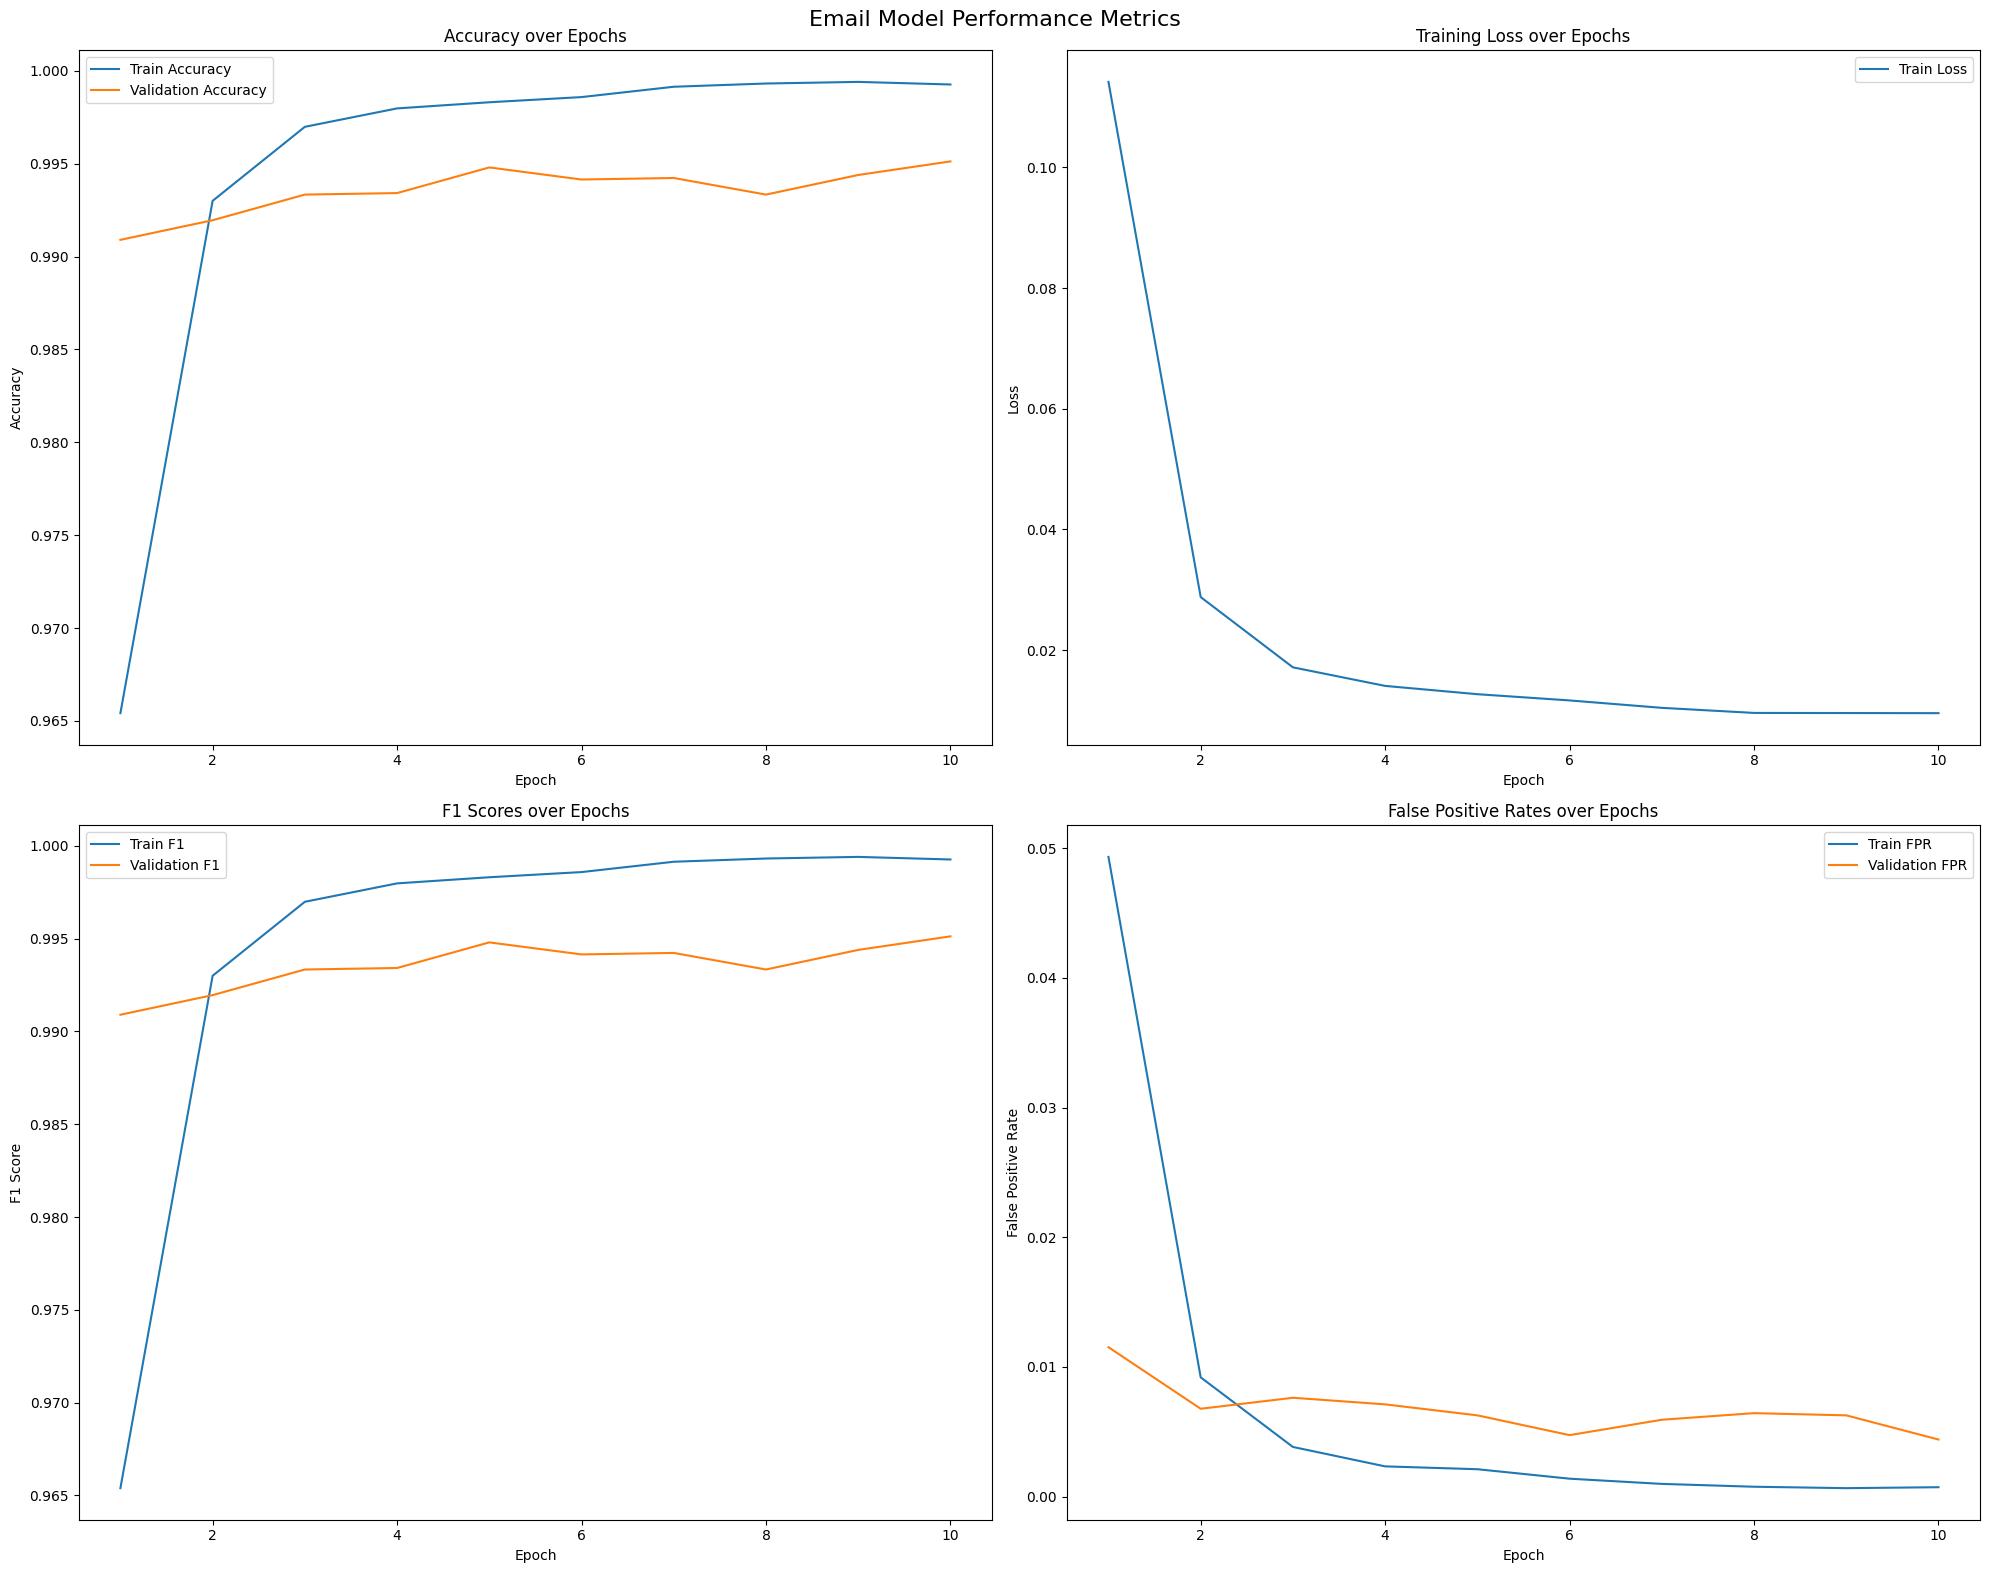

Visualization has been saved as 'email_model_performance.png'


<Figure size 640x480 with 0 Axes>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import io

# Read the CSV data from the provided string
csv_data = '''Epoch,Train Loss,Train Accuracy,Train Precision,Train Recall,Train F1,Train FPR,Val Accuracy,Val Precision,Val Recall,Val F1,Val FPR,Val Inference Time,Threshold,ROC AUC
1,0.11417896203325444,0.9654158109095973,0.9656652250609562,0.9654158109095973,0.9653902745182049,0.04933177535967283,0.99090318388564,0.9909091828750008,0.99090318388564,0.9909024104358563,0.01152542372881356,0.00018115179967849264,0.5891271,0.999434878458822
2,0.028799597454466804,0.9930030981306784,0.9930081666018374,0.9930030981306784,0.9930024947997796,0.009201781932374207,0.9919590643274854,0.9919647912666222,0.9919590643274854,0.991959562003594,0.006779661016949152,0.0001846545117485438,0.5668801,0.9995936379880943
3,0.017156085157601,0.9969888954641974,0.996989540367595,0.9969888954641974,0.996988803489159,0.003834075805155919,0.9933398310591293,0.9933403051621211,0.9933398310591293,0.9933396479555833,0.007627118644067797,0.00018296755312943784,0.18518947,0.9996269441830465
4,0.014079464319211851,0.9979809934904446,0.9979810411209252,0.9979809934904446,0.9979809736737176,0.002336960490761703,0.993421052631579,0.9934210364577974,0.993421052631579,0.9934209854595878,0.00711864406779661,0.00018309963996569935,0.61260873,0.9995355239646002
5,0.012705253670510643,0.9983116928325269,0.9983118590647964,0.9983116928325269,0.9983116665268187,0.002117870444752793,0.9948018193632229,0.9948027756694978,0.9948018193632229,0.9948016400360797,0.006271186440677966,0.00018233827680175067,0.28012028,0.9996961867050128
6,0.01167277125346128,0.9985901764890173,0.9985902031056559,0.9985901764890173,0.998590182218118,0.0013875702913897611,0.9941520467836257,0.9941560230300931,0.9941520467836257,0.9941523534412365,0.0047457627118644066,0.0001827192585370694,0.30755883,0.9996016341182317
7,0.010443285918371433,0.9991471438019981,0.9991471520119097,0.9991471438019981,0.9991471403232429,0.0009859052070400934,0.9942332683560754,0.994233320442998,0.9942332683560754,0.9942332878294936,0.005932203389830509,0.0001901969884881112,0.19959024,0.9996259264937565
8,0.00960161205342782,0.9993211960873046,0.999321198228414,0.9993211960873046,0.9993211944272635,0.0007668151610311838,0.9933398310591293,0.9933405708797863,0.9933398310591293,0.9933399646768215,0.006440677966101695,0.00020462539848218575,0.9856865,0.9995228755405648
9,0.009582836118698916,0.9994082222299578,0.9994082227284599,0.9994082222299578,0.9994082212655087,0.000657270138026729,0.9943957115009746,0.9943958486050783,0.9943957115009746,0.9943956157616674,0.006271186440677966,0.00018725523397161869,0.65631247,0.9990781453207439
10,0.009562408721918667,0.9992689804017126,0.9992689852079327,0.9992689804017126,0.9992689815913081,0.0007303001533630323,0.9951267056530214,0.9951278069825049,0.9951267056530214,0.9951268354947606,0.004406779661016949,0.0001859866116556585,0.66177905,0.9996659335779312'''

df = pd.read_csv(io.StringIO(csv_data))

# Create a figure with multiple subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Email Model Performance Metrics', fontsize=16)

# Plot 1: Training and Validation Accuracy
axs[0, 0].plot(df['Epoch'], df['Train Accuracy'], label='Train Accuracy')
axs[0, 0].plot(df['Epoch'], df['Val Accuracy'], label='Validation Accuracy')
axs[0, 0].set_title('Accuracy over Epochs')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Plot 2: Training Loss
axs[0, 1].plot(df['Epoch'], df['Train Loss'], label='Train Loss')
axs[0, 1].set_title('Training Loss over Epochs')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Plot 3: F1 Scores
axs[1, 0].plot(df['Epoch'], df['Train F1'], label='Train F1')
axs[1, 0].plot(df['Epoch'], df['Val F1'], label='Validation F1')
axs[1, 0].set_title('F1 Scores over Epochs')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('F1 Score')
axs[1, 0].legend()

# Plot 4: False Positive Rates
axs[1, 1].plot(df['Epoch'], df['Train FPR'], label='Train FPR')
axs[1, 1].plot(df['Epoch'], df['Val FPR'], label='Validation FPR')
axs[1, 1].set_title('False Positive Rates over Epochs')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('False Positive Rate')
axs[1, 1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('/kaggle/working/email_model_performance.png')
print("Visualization has been saved as 'email_model_performance.png'")

# URL Phishing Model Training

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import numpy as np
import time
import os
from tqdm import tqdm
import csv
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 32
ACCUMULATION_STEPS = 2
EPOCHS = 50
LEARNING_RATE = 2e-5
MAX_LENGTH = 128  # URLs are typically shorter than emails
MODEL_NAME = 'distilbert-base-uncased'
USE_FP16 = True
MAX_DATASET_SIZE = None  # Use full dataset

# Target metrics
TARGET_ACCURACY = 0.985
TARGET_RESPONSE_TIME = 0.200  # 200 milliseconds
TARGET_FPR = 0.01  # 1%

class CustomDistilBERTForURLClassification(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(config.dim, config.dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(config.dim // 2, config.num_labels)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        outputs = (logits,) + distilbert_output[1:]
        
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(device))
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs
            
            probs = torch.softmax(logits, dim=1)
            fpr = ((1 - labels) * probs[:, 1]).mean()
            custom_loss = loss + self.alpha * (fpr - TARGET_FPR).abs()
            outputs = (custom_loss,) + outputs[1:]
        
        return outputs

def load_and_preprocess_data(data_path, tokenizer):
    data = torch.load(data_path)
    if MAX_DATASET_SIZE and len(data) > MAX_DATASET_SIZE:
        data = Subset(data, range(MAX_DATASET_SIZE))
    
    # Assuming data is a TensorDataset with input_ids, attention_mask, and labels
    input_ids = data.tensors[0]
    attention_mask = data.tensors[1]
    labels = data.tensors[2]
    
    # Create a new TensorDataset with the existing tensors
    dataset = TensorDataset(input_ids, attention_mask, labels)
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

def create_model(num_labels):
    model = CustomDistilBERTForURLClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
    return model.to(device)

def train_epoch(model, dataloader, optimizer, scheduler, epoch, scaler):
    model.train()
    total_loss = 0
    predictions, true_labels = [], []
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    for step, batch in enumerate(progress_bar):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.cuda.amp.autocast(enabled=USE_FP16):
            outputs = model(**inputs)
            loss = outputs[0] / ACCUMULATION_STEPS

        scaler.scale(loss).backward()

        if (step + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * ACCUMULATION_STEPS
        predictions.extend(outputs[1].argmax(dim=-1).cpu().numpy())
        true_labels.extend(inputs['labels'].cpu().numpy())
        
        progress_bar.set_postfix({'loss': f'{loss.item() * ACCUMULATION_STEPS:.3f}'})

    avg_loss = total_loss / len(dataloader)
    return avg_loss, predictions, true_labels

def find_optimal_threshold(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    return thresholds[optimal_idx]

def calculate_metrics(predictions, true_labels, threshold=0.5):
    if isinstance(predictions[0], np.ndarray):
        binary_predictions = (predictions[:, 1] > threshold).astype(int)
    else:
        binary_predictions = predictions
    
    accuracy = accuracy_score(true_labels, binary_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, binary_predictions, average='weighted')
    conf_matrix = confusion_matrix(true_labels, binary_predictions)
    
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    
    return accuracy, precision, recall, f1, conf_matrix, fpr

def measure_inference_time(model, dataloader):
    model.eval()
    total_time = 0
    num_samples = 0
    
    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
            
            start_time = time.time()
            _ = model(**inputs)
            end_time = time.time()
            
            total_time += (end_time - start_time)
            num_samples += batch[0].size(0)
    
    avg_inference_time = total_time / num_samples
    return avg_inference_time

def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1]}
            labels = batch[2]

            outputs = model(**inputs)
            logits = outputs[0]
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            predictions.extend(probs)
            true_labels.extend(labels.cpu().numpy())
    
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    optimal_threshold = find_optimal_threshold(true_labels, predictions[:, 1])
    
    accuracy, precision, recall, f1, conf_matrix, fpr = calculate_metrics(predictions, true_labels, optimal_threshold)
    inference_time = measure_inference_time(model, dataloader)
    
    fpr_curve, tpr, _ = roc_curve(true_labels, predictions[:, 1])
    roc_auc = auc(fpr_curve, tpr)
    
    return accuracy, precision, recall, f1, conf_matrix, fpr, inference_time, optimal_threshold, roc_auc

def log_metrics(log_file, epoch, train_loss, train_accuracy, train_precision, train_recall, train_f1, train_fpr,
                val_accuracy, val_precision, val_recall, val_f1, val_fpr, val_inference_time, threshold, roc_auc):
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    
    if not os.path.exists(log_file):
        with open(log_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Train Precision', 'Train Recall', 'Train F1', 'Train FPR',
                             'Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1', 'Val FPR', 'Val Inference Time', 'Threshold', 'ROC AUC'])
    
    with open(log_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, train_accuracy, train_precision, train_recall, train_f1, train_fpr,
                         val_accuracy, val_precision, val_recall, val_f1, val_fpr, val_inference_time, threshold, roc_auc])

def train_model(train_data_path, val_data_path, num_labels, save_dir):
    try:
        os.makedirs(save_dir, exist_ok=True)

        tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
        train_dataloader = load_and_preprocess_data(train_data_path, tokenizer)
        val_dataloader = load_and_preprocess_data(val_data_path, tokenizer)

        model = create_model(num_labels)
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
        total_steps = len(train_dataloader) * EPOCHS
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
        lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

        scaler = torch.cuda.amp.GradScaler(enabled=USE_FP16)

        log_file = os.path.join(save_dir, 'training_log.csv')

        best_val_f1 = 0
        best_threshold = 0.5
        patience = 10
        no_improve_epochs = 0

        for epoch in range(EPOCHS):
            print(f"\nEpoch {epoch+1}/{EPOCHS}")
            start_time = time.time()

            train_loss, train_predictions, train_true_labels = train_epoch(model, train_dataloader, optimizer, scheduler, epoch, scaler)
            train_accuracy, train_precision, train_recall, train_f1, train_conf_matrix, train_fpr = calculate_metrics(train_predictions, train_true_labels)

            val_accuracy, val_precision, val_recall, val_f1, val_conf_matrix, val_fpr, val_inference_time, optimal_threshold, roc_auc = evaluate_model(model, val_dataloader)

            log_metrics(log_file, epoch+1, train_loss, train_accuracy, train_precision, train_recall, train_f1, train_fpr,
                        val_accuracy, val_precision, val_recall, val_f1, val_fpr, val_inference_time, optimal_threshold, roc_auc)

            print(f"Train Loss: {train_loss:.4f}")
            print(f"Train Metrics - Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, FPR: {train_fpr:.4f}")
            print(f"Validation Metrics - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, FPR: {val_fpr:.4f}")
            print(f"Validation Inference Time: {val_inference_time*1000:.2f} ms")
            print(f"Optimal Threshold: {optimal_threshold:.4f}")
            print(f"ROC AUC: {roc_auc:.4f}")
            print(f"Validation Confusion Matrix:\n{val_conf_matrix}")

            lr_scheduler.step(val_f1)

            if val_accuracy >= TARGET_ACCURACY and val_inference_time <= TARGET_RESPONSE_TIME and val_fpr <= TARGET_FPR:
                print("Target metrics achieved! Stopping training.")
                torch.save(model.state_dict(), os.path.join(save_dir, 'final_model.pth'))
                break

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_threshold = optimal_threshold
                torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1

            if no_improve_epochs >= patience:
                print(f"No improvement for {patience} epochs. Early stopping.")
                break

            print(f"Epoch completed in {time.time() - start_time:.2f} seconds")

        print("Training completed!")
        print(f"Training log saved to {log_file}")
        print(f"Best validation F1: {best_val_f1:.4f}")
        print(f"Best threshold: {best_threshold:.4f}")

        # Quantize the model for faster inference
        quantized_model = torch.quantization.quantize_dynamic(
            model, {torch.nn.Linear}, dtype=torch.qint8
        )
        torch.save(quantized_model.state_dict(), os.path.join(save_dir, 'quantized_model.pth'))

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    data_train_path = "/kaggle/working/url_b_distilbert_processed_data/train_data.pt"
    data_val_path = "/kaggle/working/url_b_distilbert_processed_data/val_data.pt"
    save_dir = "/kaggle/working/url_phishing_model_distilbert"
    
    print("Training DistilBERT URL Phishing Detection Model")
    train_model(data_train_path, data_val_path, num_labels=2, save_dir=save_dir)

# URL ModelTraining Perfomance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import io

# Read the CSV data
csv_data = '''Epoch,Train Loss,Train Accuracy,Train Precision,Train Recall,Train F1,Train FPR,Val Loss,Val Accuracy,Val Precision,Val Recall,Val F1,Val FPR,Val Inference Time,Val AUC
1,0.0029982850779205913,0.9985193666837762,0.998785481296412,0.9986122194081116,0.9986988428375635,0.0016032247721130502,0.017807669012221167,0.9880228487193662,0.9929180750040238,0.9862509992006395,0.9895733076676291,0.009567297238530115,0.00017241114122071977,0.9883418509810548
2,0.0010051630795385243,0.9990129111225174,0.9991672738628083,0.9990979426152725,0.9991326070362917,0.0010993541294489488,0.02305852224587986,0.9836005159388244,0.9757319555346798,0.9963229416466827,0.9859199493750989,0.03370297890845836,0.00016939549984711408,0.9813099813691121
3,0.0008012066835587574,0.9991511035653651,0.9994446758295155,0.9990632481004753,0.9992539255660623,0.0007329027529659658,0.018481470520460414,0.9882071125852221,0.9940332204483148,0.9854516386890487,0.9897238278741168,0.008045227223309415,0.00016882882189394823,0.9887032057328696
4,0.0006351017832036879,0.9994077466735105,0.999548908706062,0.9994101932484474,0.999479546164255,0.0005954834867848472,0.020342647573654164,0.9888520361157177,0.9897796231236027,0.9908872901678657,0.9903331469201885,0.013916068710589258,0.00016924290229146466,0.9884856107286382
5,0.0006056513637648168,0.9994669720061594,0.9995489556588717,0.9995142767928391,0.9995316159250586,0.0005954834867848472,0.024237477508623494,0.9867330016583747,0.9944974915034795,0.982414068745004,0.9884188515361108,0.007392911502500543,0.00017049915776938963,0.9875105786212517
6,0.0006156040842392179,0.9993090377857622,0.9994794919841765,0.9993061097040558,0.9993927933241962,0.000687096330905593,0.019031751200521165,0.9878385848535103,0.99307456917378,0.985771382893685,0.9894094993581515,0.009349858664927158,0.00016923275401584787,0.9882107621143789
7,0.000245325900818332,0.9998223240020532,0.9998612171258067,0.999826527426014,0.9998438719750196,0.00018322568824149146,0.025448889396048457,0.9881149806522941,0.9910227637063161,0.9883293365307754,0.9896742175618346,0.0121765601217656,0.00016971396240099415,0.9880763882045049
8,0.0010583681033673837,0.9988944604572195,0.999097817412124,0.9989591645560837,0.9990284861732764,0.0011909669735696944,0.01915304686569223,0.9876543209876543,0.9894450663681433,0.9891286970423661,0.9892868564118964,0.014350945857795172,0.00016824648220806638,0.9873888755922854
9,8.880298380319854e-05,0.9999605164449007,1.0,0.9999306109704056,0.9999653042814517,0.0,0.024395825895467987,0.9880228487193662,0.9905494153451866,0.9886490807354117,0.9895983357337175,0.012828875842574472,0.00017108889998532098,0.9879101024464185
10,3.596195897587971e-05,0.9999407746673511,1.0,0.9998959164556084,0.9999479555193173,0.0,0.029599423531033134,0.9877464529205823,0.9916479280436877,0.9870503597122302,0.9893438025799215,0.011306805827353772,0.00016941729008393633,0.9878717769424382
11,0.00032089497770401075,0.9997236151143049,0.9997918184657021,0.9997224438816223,0.9997571299701618,0.0002748385323622372,0.02216361054628284,0.9879307167864382,0.9882015306122449,0.9908872901678657,0.9895425880098987,0.01609045444661883,0.0001694497997114534,0.9873984178606233
12,8.362478071858606e-05,0.9999210328898014,0.9999306109704056,0.9999306109704056,0.9999306109704056,9.161284412074573e-05,0.0227283054021064,0.9877464529205823,0.9888214627914405,0.9899280575539569,0.9893744507469842,0.015220700152207,0.0001690737423985532,0.9873536787008749
13,0.00010822285391711252,0.9998815493347021,0.9998959164556084,0.9998959164556084,0.9998959164556084,0.0001374192661811186,0.023338521913642465,0.9885756403169339,0.9902446825523749,0.9899280575539569,0.9900863447393667,0.013263752989780386,0.0001706853412848185,0.9883321522820883
14,4.6800396093042445e-05,0.9999210328898014,0.9999306109704056,0.9999306109704056,0.9999306109704056,9.161284412074573e-05,0.025369618052155464,0.9880228487193662,0.9892954146029718,0.9899280575539569,0.989611634968835,0.01456838443139813,0.0001683715783761135,0.9876798365612793'''

df = pd.read_csv(io.StringIO(csv_data))

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 24))
fig.suptitle('URL Phishing Detection Model: Training vs Validation Metrics', fontsize=16)

# Plot Accuracy
axs[0, 0].plot(df['Epoch'], df['Train Accuracy'], label='Train')
axs[0, 0].plot(df['Epoch'], df['Val Accuracy'], label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Plot Loss
axs[0, 1].plot(df['Epoch'], df['Train Loss'], label='Train')
axs[0, 1].plot(df['Epoch'], df['Val Loss'], label='Validation')
axs[0, 1].set_title('Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Plot Precision
axs[1, 0].plot(df['Epoch'], df['Train Precision'], label='Train')
axs[1, 0].plot(df['Epoch'], df['Val Precision'], label='Validation')
axs[1, 0].set_title('Precision')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend()

# Plot Recall
axs[1, 1].plot(df['Epoch'], df['Train Recall'], label='Train')
axs[1, 1].plot(df['Epoch'], df['Val Recall'], label='Validation')
axs[1, 1].set_title('Recall')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend()

# Plot F1 Score
axs[2, 0].plot(df['Epoch'], df['Train F1'], label='Train')
axs[2, 0].plot(df['Epoch'], df['Val F1'], label='Validation')
axs[2, 0].set_title('F1 Score')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].set_ylabel('F1 Score')
axs[2, 0].legend()

# Plot False Positive Rate
axs[2, 1].plot(df['Epoch'], df['Train FPR'], label='Train')
axs[2, 1].plot(df['Epoch'], df['Val FPR'], label='Validation')
axs[2, 1].set_title('False Positive Rate')
axs[2, 1].set_xlabel('Epoch')
axs[2, 1].set_ylabel('FPR')
axs[2, 1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('/kaggle/working/url_model_metrics_comparison.png')
print("Visualization has been saved as 'url_model_metrics_comparison.png'")

# Resume URL Phishing Model Training

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from transformers import DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import numpy as np
import time
import os
from tqdm import tqdm
import csv
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 32
ACCUMULATION_STEPS = 2
EPOCHS = 50
LEARNING_RATE = 1e-5  # Reduced learning rate for fine-tuning
MAX_LENGTH = 128
MODEL_NAME = 'distilbert-base-uncased'
USE_FP16 = True
MAX_DATASET_SIZE = None  # Use full dataset

# Target metrics
TARGET_ACCURACY = 0.995
TARGET_RESPONSE_TIME = 0.200  # 200 milliseconds
TARGET_FPR = 0.01  # 1%

# Path to the saved model
SAVED_MODEL_PATH = "/kaggle/working/url_phishing_model_distilbert/best_model.pth"

class CustomDistilBERTForURLClassification(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(config.dim, config.dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(config.dim // 2, config.num_labels)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        outputs = (logits,) + distilbert_output[1:]
        
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(device))
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs
            
            probs = torch.softmax(logits, dim=1)
            fpr = ((1 - labels) * probs[:, 1]).mean()
            custom_loss = loss + self.alpha * (fpr - TARGET_FPR).abs()
            outputs = (custom_loss,) + outputs[1:]
        
        return outputs

def load_and_preprocess_data(data_path, tokenizer):
    data = torch.load(data_path)
    if MAX_DATASET_SIZE and len(data) > MAX_DATASET_SIZE:
        data = Subset(data, range(MAX_DATASET_SIZE))
    
    # Assuming data is already a TensorDataset with input_ids, attention_mask, and labels
    return DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

def create_model(num_labels):
    model = CustomDistilBERTForURLClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
    return model.to(device)

def train_epoch(model, dataloader, optimizer, scheduler, epoch, scaler):
    model.train()
    total_loss = 0
    predictions, true_labels = [], []
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    for step, batch in enumerate(progress_bar):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.cuda.amp.autocast(enabled=USE_FP16):
            outputs = model(**inputs)
            loss = outputs[0] / ACCUMULATION_STEPS

        scaler.scale(loss).backward()

        if (step + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * ACCUMULATION_STEPS
        predictions.extend(outputs[1].argmax(dim=-1).cpu().numpy())
        true_labels.extend(inputs['labels'].cpu().numpy())
        
        progress_bar.set_postfix({'loss': f'{loss.item() * ACCUMULATION_STEPS:.3f}'})

    avg_loss = total_loss / len(dataloader)
    return avg_loss, predictions, true_labels

def find_optimal_threshold(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    return thresholds[optimal_idx]

def calculate_metrics(predictions, true_labels, threshold=0.5):
    if isinstance(predictions[0], np.ndarray):
        binary_predictions = (predictions[:, 1] > threshold).astype(int)
    else:
        binary_predictions = predictions
    
    accuracy = accuracy_score(true_labels, binary_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, binary_predictions, average='weighted')
    conf_matrix = confusion_matrix(true_labels, binary_predictions)
    
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    
    return accuracy, precision, recall, f1, conf_matrix, fpr

def measure_inference_time(model, dataloader):
    model.eval()
    total_time = 0
    num_samples = 0
    
    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
            
            start_time = time.time()
            _ = model(**inputs)
            end_time = time.time()
            
            total_time += (end_time - start_time)
            num_samples += batch[0].size(0)
    
    avg_inference_time = total_time / num_samples
    return avg_inference_time

def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1]}
            labels = batch[2]

            outputs = model(**inputs)
            logits = outputs[0]
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            predictions.extend(probs)
            true_labels.extend(labels.cpu().numpy())
    
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    optimal_threshold = find_optimal_threshold(true_labels, predictions[:, 1])
    
    accuracy, precision, recall, f1, conf_matrix, fpr = calculate_metrics(predictions, true_labels, optimal_threshold)
    inference_time = measure_inference_time(model, dataloader)
    
    fpr_curve, tpr, _ = roc_curve(true_labels, predictions[:, 1])
    roc_auc = auc(fpr_curve, tpr)
    
    return accuracy, precision, recall, f1, conf_matrix, fpr, inference_time, optimal_threshold, roc_auc

def log_metrics(log_file, epoch, train_loss, train_accuracy, train_precision, train_recall, train_f1, train_fpr,
                val_accuracy, val_precision, val_recall, val_f1, val_fpr, val_inference_time, threshold, roc_auc):
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    
    if not os.path.exists(log_file):
        with open(log_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Train Precision', 'Train Recall', 'Train F1', 'Train FPR',
                             'Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1', 'Val FPR', 'Val Inference Time', 'Threshold', 'ROC AUC'])
    
    with open(log_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, train_accuracy, train_precision, train_recall, train_f1, train_fpr,
                         val_accuracy, val_precision, val_recall, val_f1, val_fpr, val_inference_time, threshold, roc_auc])

def resume_training(train_data_path, val_data_path, num_labels, save_dir):
    try:
        os.makedirs(save_dir, exist_ok=True)

        train_dataloader = load_and_preprocess_data(train_data_path, None)
        val_dataloader = load_and_preprocess_data(val_data_path, None)

        # Load the saved model
        model = CustomDistilBERTForURLClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
        model.load_state_dict(torch.load(SAVED_MODEL_PATH))
        model = model.to(device)

        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
        total_steps = len(train_dataloader) * EPOCHS
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
        lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

        scaler = torch.cuda.amp.GradScaler(enabled=USE_FP16)

        log_file = os.path.join(save_dir, 'resumed_training_log.csv')

        best_val_f1 = 0
        best_threshold = 0.5
        patience = 10
        no_improve_epochs = 0

        for epoch in range(EPOCHS):
            print(f"\nEpoch {epoch+1}/{EPOCHS}")
            start_time = time.time()

            train_loss, train_predictions, train_true_labels = train_epoch(model, train_dataloader, optimizer, scheduler, epoch, scaler)
            train_accuracy, train_precision, train_recall, train_f1, train_conf_matrix, train_fpr = calculate_metrics(train_predictions, train_true_labels)

            val_accuracy, val_precision, val_recall, val_f1, val_conf_matrix, val_fpr, val_inference_time, optimal_threshold, roc_auc = evaluate_model(model, val_dataloader)

            log_metrics(log_file, epoch+1, train_loss, train_accuracy, train_precision, train_recall, train_f1, train_fpr,
                        val_accuracy, val_precision, val_recall, val_f1, val_fpr, val_inference_time, optimal_threshold, roc_auc)

            print(f"Train Loss: {train_loss:.4f}")
            print(f"Train Metrics - Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, FPR: {train_fpr:.4f}")
            print(f"Validation Metrics - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, FPR: {val_fpr:.4f}")
            print(f"Validation Inference Time: {val_inference_time*1000:.2f} ms")
            print(f"Optimal Threshold: {optimal_threshold:.4f}")
            print(f"ROC AUC: {roc_auc:.4f}")
            print(f"Validation Confusion Matrix:\n{val_conf_matrix}")

            lr_scheduler.step(val_f1)

            if val_accuracy >= TARGET_ACCURACY and val_inference_time <= TARGET_RESPONSE_TIME and val_fpr <= TARGET_FPR:
                print("Target metrics achieved! Stopping training.")
                torch.save(model.state_dict(), os.path.join(save_dir, 'final_model_resumed.pth'))
                break

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_threshold = optimal_threshold
                torch.save(model.state_dict(), os.path.join(save_dir, 'best_model_resumed.pth'))
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1

            if no_improve_epochs >= patience:
                print(f"No improvement for {patience} epochs. Early stopping.")
                break

            print(f"Epoch completed in {time.time() - start_time:.2f} seconds")

        print("Resumed training completed!")
        print(f"Training log saved to {log_file}")
        print(f"Best validation F1: {best_val_f1:.4f}")
        print(f"Best threshold: {best_threshold:.4f}")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    data_train_path = "/kaggle/working/url_b_distilbert_processed_data/train_data.pt"
    data_val_path = "/kaggle/working/url_b_distilbert_processed_data/val_data.pt"
    save_dir = "/kaggle/working/url_phishing_model_distilbert_resumed"
    
    print("Resuming Training for Enhanced DistilBERT URL Phishing Detection Model")
    resume_training(data_train_path, data_val_path, num_labels=2, save_dir=save_dir)

# Resume Email Phishing Model Training

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import numpy as np
import time
import os
from tqdm import tqdm
import csv
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 32
ACCUMULATION_STEPS = 2
ADDITIONAL_EPOCHS = 15
LEARNING_RATE = 1e-5  # Lower learning rate for fine-tuning
MAX_LENGTH = 256
MODEL_NAME = 'distilbert-base-uncased'
USE_FP16 = True

# Target metrics
TARGET_ACCURACY = 0.985
TARGET_RESPONSE_TIME = 0.200  # 200 milliseconds
TARGET_FPR = 0.01  # 1%

class CustomDistilBERTForSequenceClassification(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(config.dim, config.dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(config.dim // 2, config.num_labels)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        outputs = (logits,) + distilbert_output[1:]
        
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(device))
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs
            
            probs = torch.softmax(logits, dim=1)
            fpr = ((1 - labels) * probs[:, 1]).mean()
            custom_loss = loss + self.alpha * (fpr - TARGET_FPR).abs()
            outputs = (custom_loss,) + outputs[1:]
        
        return outputs

def load_data(data_path):
    data = torch.load(data_path)
    return DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

def create_model(num_labels, model_path):
    model = CustomDistilBERTForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model.to(device)

def train_epoch(model, dataloader, optimizer, scheduler, epoch, scaler):
    model.train()
    total_loss = 0
    predictions, true_labels = [], []
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    for step, batch in enumerate(progress_bar):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.cuda.amp.autocast(enabled=USE_FP16):
            outputs = model(**inputs)
            loss = outputs[0] / ACCUMULATION_STEPS

        scaler.scale(loss).backward()

        if (step + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * ACCUMULATION_STEPS
        predictions.extend(outputs[1].argmax(dim=-1).cpu().numpy())
        true_labels.extend(inputs['labels'].cpu().numpy())
        
        progress_bar.set_postfix({'loss': f'{loss.item() * ACCUMULATION_STEPS:.3f}'})

    avg_loss = total_loss / len(dataloader)
    return avg_loss, predictions, true_labels

def evaluate_model(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1]}
            labels = batch[2]

            outputs = model(**inputs)
            logits = outputs[0]
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            predictions.extend(probs)
            true_labels.extend(labels.cpu().numpy())
    
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    fpr, tpr, thresholds = roc_curve(true_labels, predictions[:, 1])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    binary_predictions = (predictions[:, 1] > optimal_threshold).astype(int)
    accuracy = accuracy_score(true_labels, binary_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, binary_predictions, average='weighted')
    conf_matrix = confusion_matrix(true_labels, binary_predictions)
    
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr_value = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    if len(np.unique(true_labels)) == 1:
        roc_auc = 1.0 if true_labels[0] == binary_predictions[0] else 0.0
    else:
        roc_auc = auc(fpr, tpr)
    
    return accuracy, precision, recall, f1, conf_matrix, fpr_value, roc_auc, optimal_threshold

def resume_training(train_data_path, val_data_path, model_path, num_labels, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    train_dataloader = load_data(train_data_path)
    val_dataloader = load_data(val_data_path)

    model = create_model(num_labels, model_path)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_dataloader) * ADDITIONAL_EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    scaler = torch.cuda.amp.GradScaler(enabled=USE_FP16)

    log_file = os.path.join(save_dir, 'resume_training_log.csv')

    best_val_f1 = 0
    best_threshold = 0.5
    patience = 5
    no_improve_epochs = 0

    for epoch in range(ADDITIONAL_EPOCHS):
        print(f"\nEpoch {epoch+1}/{ADDITIONAL_EPOCHS}")
        start_time = time.time()

        train_loss, train_predictions, train_true_labels = train_epoch(model, train_dataloader, optimizer, scheduler, epoch, scaler)
        train_accuracy, train_precision, train_recall, train_f1, _, train_fpr, _, _ = evaluate_model(model, train_dataloader)

        val_accuracy, val_precision, val_recall, val_f1, val_conf_matrix, val_fpr, val_roc_auc, optimal_threshold = evaluate_model(model, val_dataloader)

        # Log metrics
        with open(log_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch+1, train_loss, train_accuracy, train_precision, train_recall, train_f1, train_fpr,
                             val_accuracy, val_precision, val_recall, val_f1, val_fpr, val_roc_auc, optimal_threshold])

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Train Metrics - Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, FPR: {train_fpr:.4f}")
        print(f"Validation Metrics - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, FPR: {val_fpr:.4f}")
        print(f"Validation ROC AUC: {val_roc_auc:.4f}")
        print(f"Optimal Threshold: {optimal_threshold:.4f}")
        print(f"Validation Confusion Matrix:\n{val_conf_matrix}")

        lr_scheduler.step(val_f1)

        if val_accuracy >= TARGET_ACCURACY and val_fpr <= TARGET_FPR:
            print("Target metrics achieved! Stopping training.")
            torch.save(model.state_dict(), os.path.join(save_dir, 'final_model_resumed.pth'))
            break

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_threshold = optimal_threshold
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_model_resumed.pth'))
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print(f"No improvement for {patience} epochs. Early stopping.")
            break

        print(f"Epoch completed in {time.time() - start_time:.2f} seconds")

    print("Resume training completed!")
    print(f"Training log saved to {log_file}")
    print(f"Best validation F1: {best_val_f1:.4f}")
    print(f"Best threshold: {best_threshold:.4f}")

if __name__ == "__main__":
    train_data_path = "/kaggle/input/email-phishing-model-distilbert/train_data.pt"
    val_data_path = "/kaggle/input/email-phishing-model-distilbert/val_data.pt"
    model_path = "/kaggle/working/B_email_phishing_model_distilbert/best_model.pth"
    save_dir = "/kaggle/working/c_email_phishing_model_distilbert_resumed"
    
    print("Resuming training of DistilBERT Phishing Detection Model")
    resume_training(train_data_path, val_data_path, model_path, num_labels=2, save_dir=save_dir)

# URL Phishing Model Prediction and Evaluation Script (Controlled)

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Predicting: 100%|██████████| 340/340 [00:38<00:00,  8.88it/s]


Accuracy: 0.9887
Precision: 0.9898
Recall: 0.9906
F1 Score: 0.9902
ROC AUC: 0.9883
False Positive Rate: 0.0139

Confusion Matrix:
[[4531   64]
 [  59 6201]]

Generating visualizations...


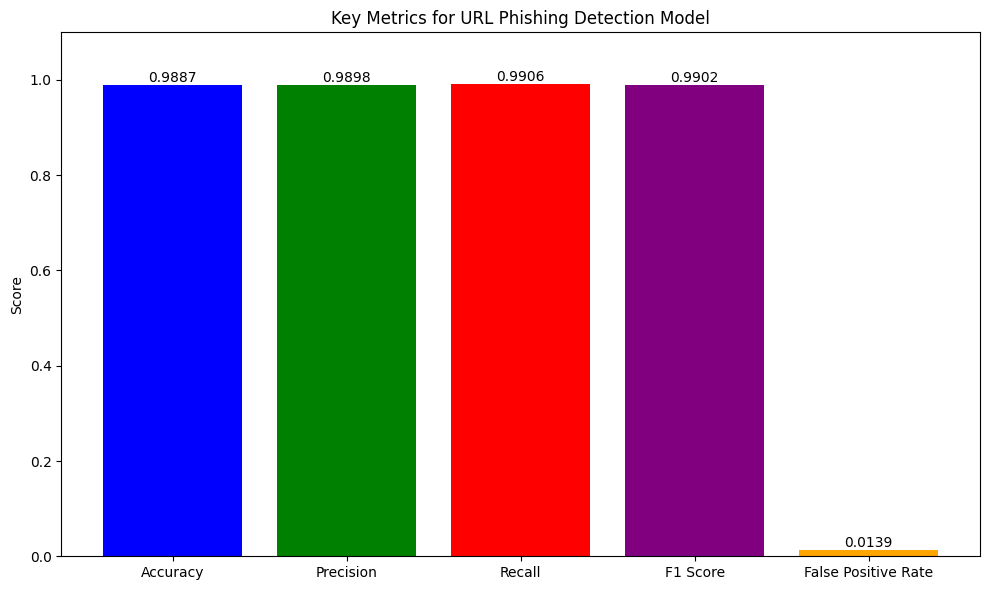

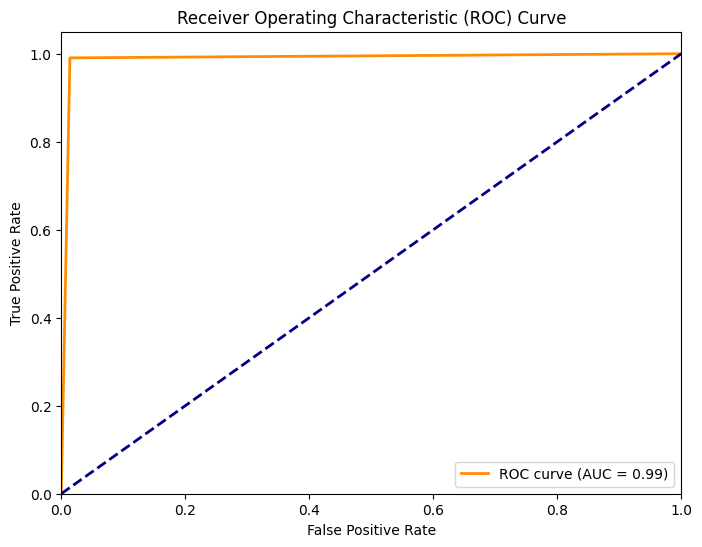

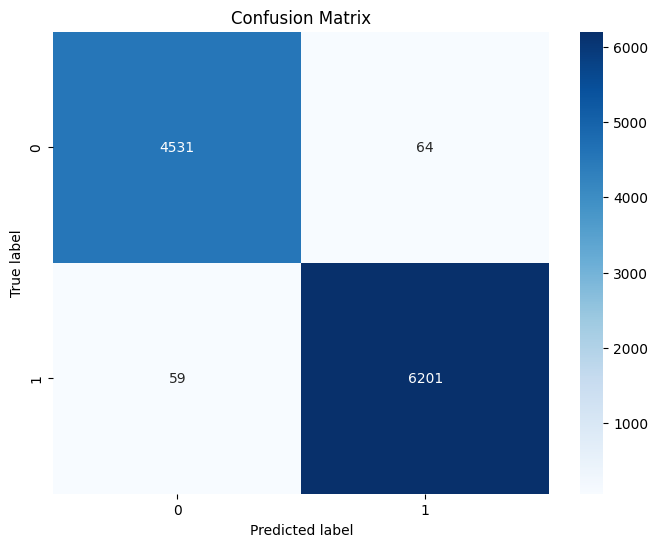

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


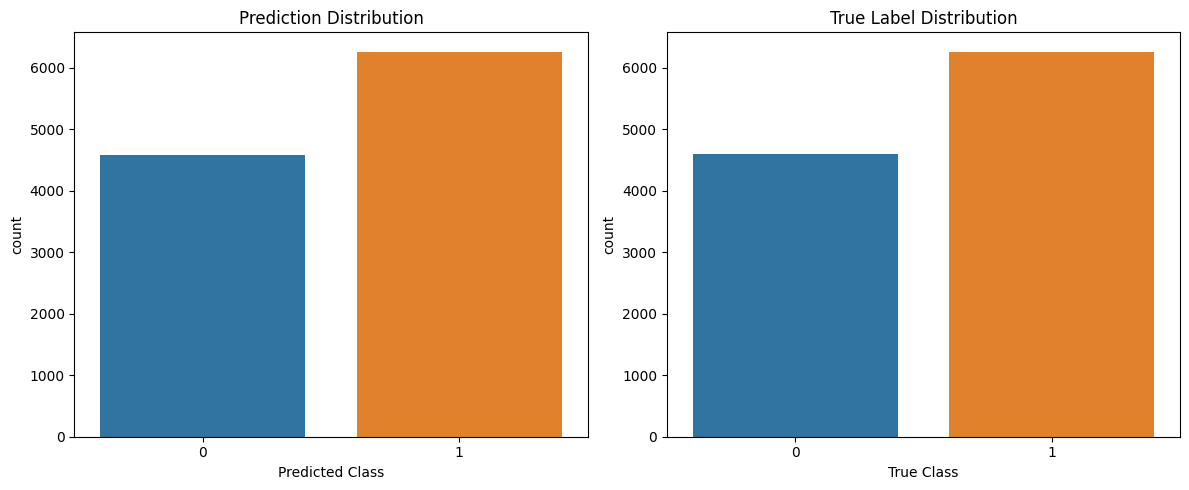

Visualizations have been displayed and saved.


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters and paths
MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 128
BATCH_SIZE = 32
MODEL_PATH = "/kaggle/input/enhanced-url-phishing-model/pytorch/distilbert/1/best_enhanced_model.pth"  # Update this path
TEST_DATA_PATH = "/kaggle/input/url-b-distilbert-processed-data/test_data.pt"  # Update this path

class EnhancedDistilBERTForURLClassification(nn.Module):
    def __init__(self, pretrained_model, num_labels):
        super(EnhancedDistilBERTForURLClassification, self).__init__()
        self.distilbert = pretrained_model
        self.pre_classifier = nn.Linear(self.distilbert.config.dim, self.distilbert.config.dim)
        self.classifier = nn.Sequential(
            nn.Linear(self.distilbert.config.dim, self.distilbert.config.dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(self.distilbert.config.dim // 2, num_labels)
        )
        self.alpha = nn.Parameter(torch.tensor(1.0))

    def forward(self, input_ids, attention_mask, handcrafted_features=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]
        pooled_output = hidden_state[:, 0]  # Use CLS token
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = nn.ReLU()(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

def load_and_preprocess_data(data_path, tokenizer):
    data = torch.load(data_path)
    input_ids = data.tensors[0]
    attention_mask = data.tensors[1]
    labels = data.tensors[2]
    
    dataset = TensorDataset(input_ids, attention_mask, labels)
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)


def plot_metrics(accuracy, precision, recall, f1, fpr):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'False Positive Rate']
    values = [accuracy, precision, recall, f1, fpr]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.title('Key Metrics for URL Phishing Detection Model')
    plt.ylabel('Score')
    plt.ylim(0, 1.1)  # Set y-axis limit from 0 to 1.1 for better visibility
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('url_key_metrics_bar_chart.png')
    plt.show()

def plot_roc_curve(true_labels, predictions):
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, predictions)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('url_roc_curve.png')
    plt.show()

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('url_confusion_matrix.png')
    plt.show()

def plot_prediction_distribution(predictions, true_labels):
    plt.figure(figsize=(12, 5))
    
    # Predictions distribution
    plt.subplot(1, 2, 1)
    sns.countplot(x=predictions)
    plt.title('Prediction Distribution')
    plt.xlabel('Predicted Class')
    
    # True label distribution
    plt.subplot(1, 2, 2)
    sns.countplot(x=true_labels)
    plt.title('True Label Distribution')
    plt.xlabel('True Class')
    
    plt.tight_layout()
    plt.savefig('url_prediction_distribution.png')
    plt.show()

def predict(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())
    
    return predictions, true_labels

def calculate_metrics(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
    conf_matrix = confusion_matrix(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, predictions)
    
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    
    return accuracy, precision, recall, f1, conf_matrix, roc_auc, fpr

def main():
    # Load the tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
    pretrained_model = DistilBertModel.from_pretrained(MODEL_NAME)
    model = EnhancedDistilBERTForURLClassification(pretrained_model, num_labels=2)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model = model.to(device)

    # Load and preprocess the test data
    test_dataloader = load_and_preprocess_data(TEST_DATA_PATH, tokenizer)

    # Make predictions
    predictions, true_labels = predict(model, test_dataloader)

    # Calculate metrics
    accuracy, precision, recall, f1, conf_matrix, roc_auc, fpr = calculate_metrics(true_labels, predictions)

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"False Positive Rate: {fpr:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Generate and display plots
    print("\nGenerating visualizations...")
    plot_metrics(accuracy, precision, recall, f1, fpr)
    plot_roc_curve(true_labels, predictions)
    plot_confusion_matrix(conf_matrix)
    plot_prediction_distribution(predictions, true_labels)
    
    print("Visualizations have been displayed and saved.")

if __name__ == "__main__":
    main()

# Email Phishing Model Prediction and Evaluation Script (Controlled)

Using device: cuda
Predicting with DistilBERT Phishing Detection Model
Loading test data...
Loading model...


Some weights of CustomDistilBERTForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['alpha', 'classifier.0.bias', 'classifier.0.weight', 'classifier.3.bias', 'classifier.3.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Making predictions...


Making predictions: 100%|██████████| 385/385 [00:39<00:00,  9.65it/s]


Evaluating predictions...

--- Test Metrics ---
Accuracy: 0.9929
Precision: 0.9929
Recall: 0.9929
F1 Score: 0.9929
False Positive Rate: 0.0069
ROC AUC: 0.9994
Optimal Threshold: 0.3862
Confusion Matrix:
[[5906   41]
 [  47 6318]]

Generating visualizations...


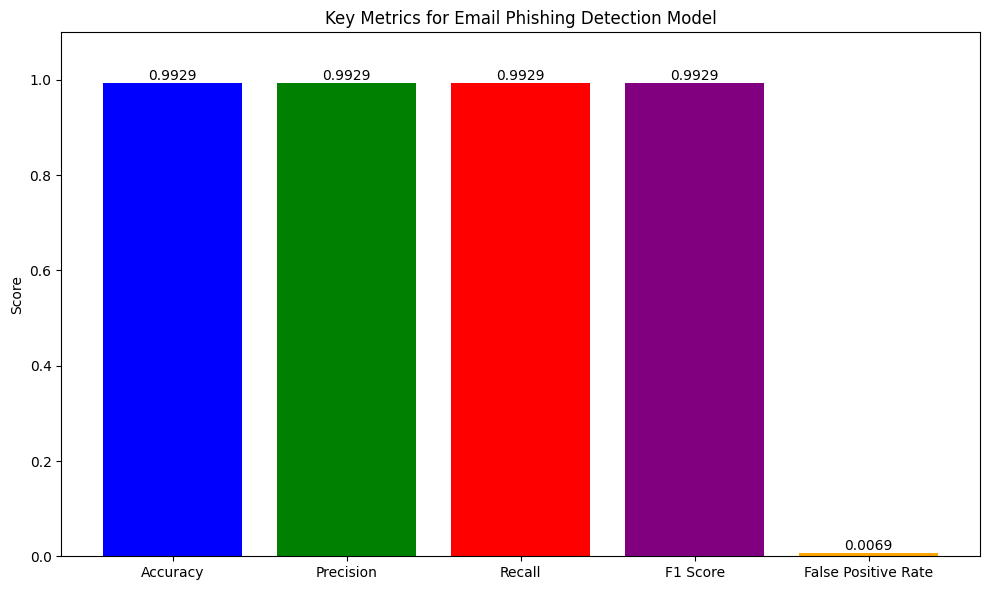

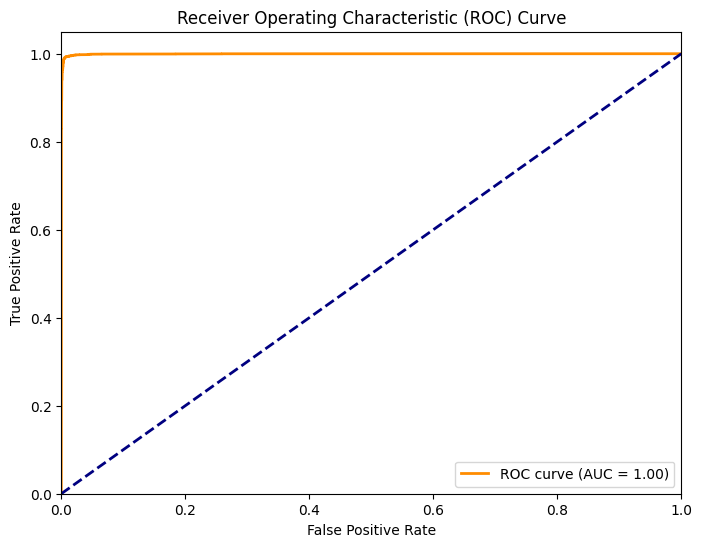

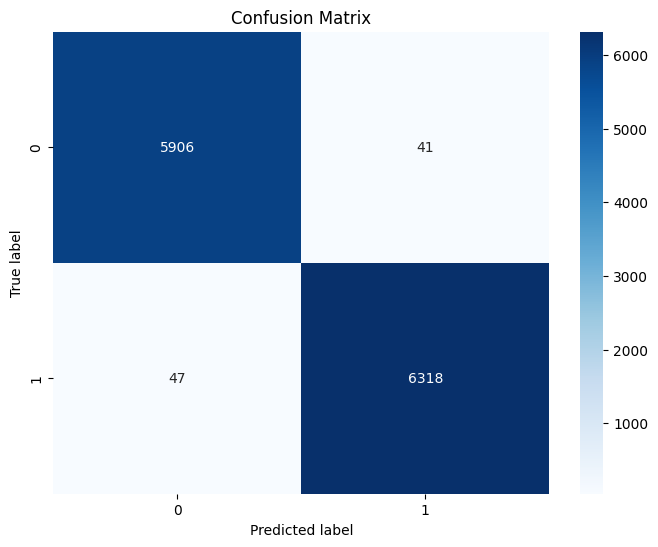

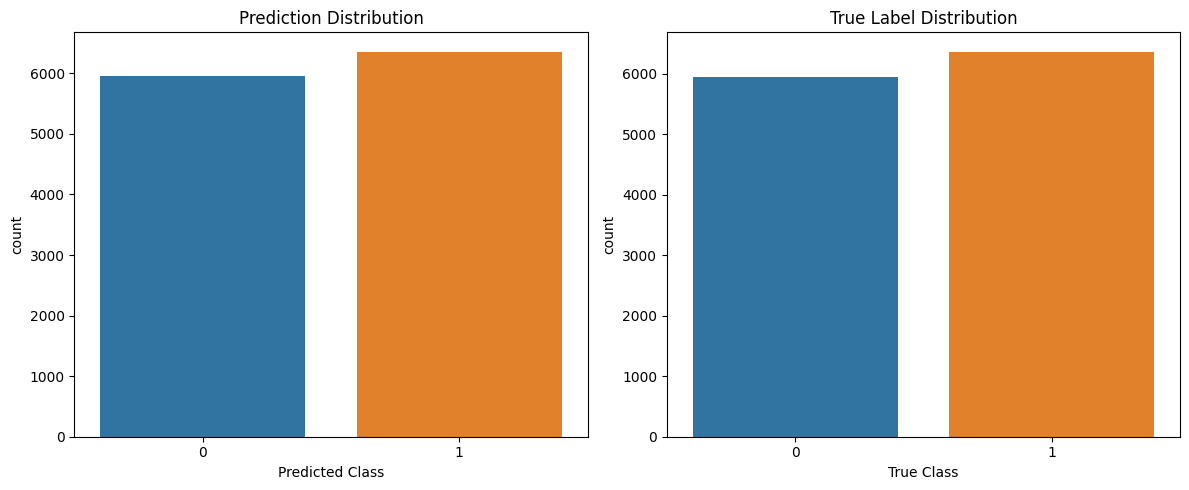

Visualizations have been displayed and saved.

Prediction distribution:
Positive predictions: 6359
Negative predictions: 5953

True label distribution:
Positive labels: 6365
Negative labels: 5947

Example predictions:
Sample 1: Predicted Phishing (confidence: 0.9996), True label: Phishing
Sample 2: Predicted Phishing (confidence: 0.9996), True label: Phishing
Sample 3: Predicted Phishing (confidence: 0.9899), True label: Phishing
Sample 4: Predicted Phishing (confidence: 0.9996), True label: Phishing
Sample 5: Predicted Phishing (confidence: 0.9997), True label: Phishing


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import numpy as np
import os
from tqdm import tqdm
import logging
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 32
MAX_LENGTH = 256
MODEL_NAME = 'distilbert-base-uncased'

class CustomDistilBERTForSequenceClassification(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(config.dim, config.dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(config.dim // 2, config.num_labels)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        outputs = (logits,) + distilbert_output[1:]
        
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs
        
        return outputs

def load_data(data_path):
    try:
        data = torch.load(data_path)
        return DataLoader(data, batch_size=BATCH_SIZE, shuffle=False)
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        sys.exit(1)

def create_model(num_labels, model_path):
    try:
        model = CustomDistilBERTForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        return model.to(device)
    except Exception as e:
        print(f"Error creating model: {str(e)}")
        sys.exit(1)

def predict(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    
    try:
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Making predictions"):
                batch = tuple(t.to(device) for t in batch)
                inputs = {'input_ids': batch[0],
                          'attention_mask': batch[1]}
                labels = batch[2]

                outputs = model(**inputs)
                logits = outputs[0]
                probs = torch.softmax(logits, dim=1).cpu().numpy()
                predictions.extend(probs)
                true_labels.extend(labels.cpu().numpy())
        
        return np.array(predictions), np.array(true_labels)
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        sys.exit(1)

def evaluate_predictions(predictions, true_labels):
    try:
        # Find optimal threshold
        fpr, tpr, thresholds = roc_curve(true_labels, predictions[:, 1])
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        
        # Calculate metrics
        binary_predictions = (predictions[:, 1] > optimal_threshold).astype(int)
        accuracy = accuracy_score(true_labels, binary_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(true_labels, binary_predictions, average='weighted')
        conf_matrix = confusion_matrix(true_labels, binary_predictions)
        
        tn, fp, fn, tp = conf_matrix.ravel()
        fpr_value = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        # Calculate ROC AUC
        if len(np.unique(true_labels)) == 1:  # All one class
            roc_auc = 1.0 if true_labels[0] == binary_predictions[0] else 0.0
        else:
            roc_auc = auc(fpr, tpr)
        
        return accuracy, precision, recall, f1, conf_matrix, fpr_value, roc_auc, optimal_threshold, binary_predictions
    except Exception as e:
        print(f"Error evaluating predictions: {str(e)}")
        sys.exit(1)

def plot_metrics(accuracy, precision, recall, f1, fpr):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'False Positive Rate']
    values = [accuracy, precision, recall, f1, fpr]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.title('Key Metrics for Email Phishing Detection Model')
    plt.ylabel('Score')
    plt.ylim(0, 1.1)  # Set y-axis limit from 0 to 1.1 for better visibility
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('key_metrics_bar_chart.png')
    plt.show()

def plot_roc_curve(true_labels, predictions):
    fpr, tpr, _ = roc_curve(true_labels, predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

def plot_prediction_distribution(binary_predictions, true_labels):
    plt.figure(figsize=(12, 5))
    
    # Predictions distribution
    plt.subplot(1, 2, 1)
    sns.countplot(x=binary_predictions)
    plt.title('Prediction Distribution')
    plt.xlabel('Predicted Class')
    
    # True label distribution
    plt.subplot(1, 2, 2)
    sns.countplot(x=true_labels)
    plt.title('True Label Distribution')
    plt.xlabel('True Class')
    
    plt.tight_layout()
    plt.savefig('prediction_distribution.png')
    plt.show()
    
def main(test_data_path, model_path, num_labels=2):
    try:
        print("Loading test data...")
        test_dataloader = load_data(test_data_path)
        
        print("Loading model...")
        model = create_model(num_labels, model_path)
        
        print("Making predictions...")
        predictions, true_labels = predict(model, test_dataloader)
        
        print("Evaluating predictions...")
        accuracy, precision, recall, f1, conf_matrix, fpr, roc_auc, optimal_threshold, binary_predictions = evaluate_predictions(predictions, true_labels)
        
        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"False Positive Rate: {fpr:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"Optimal Threshold: {optimal_threshold:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}")
        
        # Generate and display plots
        print("\nGenerating visualizations...")
        plot_metrics(accuracy, precision, recall, f1, fpr)
        plot_roc_curve(true_labels, predictions)
        plot_confusion_matrix(conf_matrix)
        plot_prediction_distribution(binary_predictions, true_labels)
        
        print("Visualizations have been displayed and saved.")
        
        # Additional debugging information
        print(f"\nPrediction distribution:")
        print(f"Positive predictions: {np.sum(binary_predictions == 1)}")
        print(f"Negative predictions: {np.sum(binary_predictions == 0)}")
        print(f"\nTrue label distribution:")
        print(f"Positive labels: {np.sum(true_labels == 1)}")
        print(f"Negative labels: {np.sum(true_labels == 0)}")
        
        return binary_predictions, predictions, true_labels
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        sys.exit(1)

if __name__ == "__main__":
    test_data_path = "/kaggle/working/new_email_distilbert_processed_data/test_data.pt"
    model_path = "/kaggle/working/new_email_phishing_model_distilbert/final_model.pth"
    
    print("Predicting with DistilBERT Phishing Detection Model")
    binary_predictions, raw_predictions, true_labels = main(test_data_path, model_path)
    
    # Example of how to use the predictions
    print("\nExample predictions:")
    for i in range(min(5, len(binary_predictions))):
        print(f"Sample {i+1}: Predicted {'Phishing' if binary_predictions[i] == 1 else 'Legitimate'} (confidence: {raw_predictions[i][1]:.4f}), True label: {'Phishing' if true_labels[i] == 1 else 'Legitimate'}")

# Email Confusion Matrix (Real-world Scenarios)

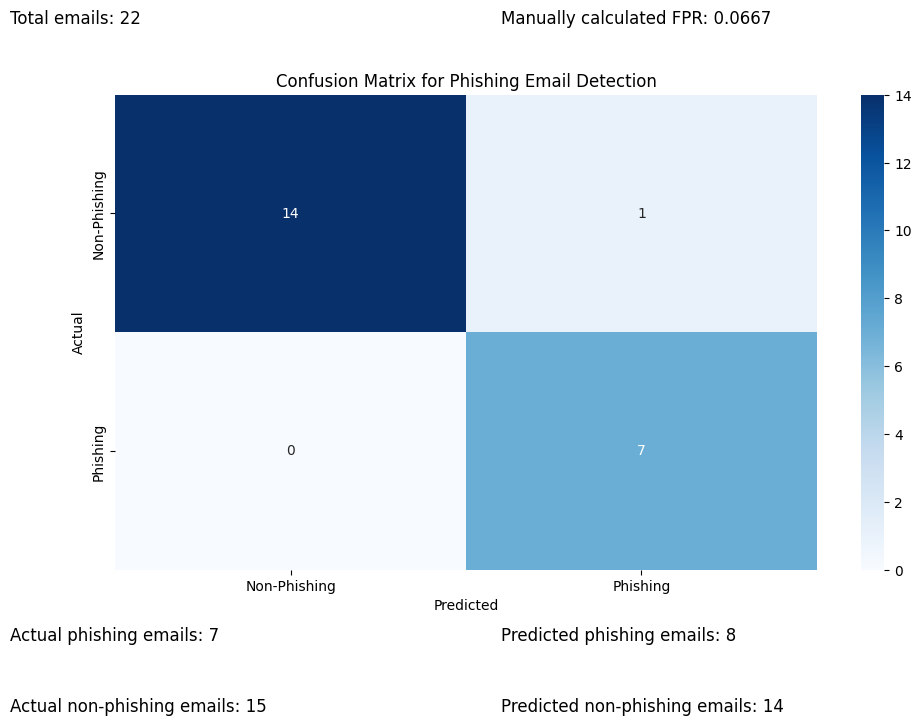

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the confusion matrix
conf_matrix = np.array([[14, 1],
                        [0, 7]])

# Create a figure and axis
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Phishing', 'Phishing'],
            yticklabels=['Non-Phishing', 'Phishing'])

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Phishing Email Detection')

# Add text annotations
plt.text(-0.3, -0.3, f"Total emails: {np.sum(conf_matrix)}", fontsize=12)
plt.text(-0.3, 2.3, f"Actual phishing emails: {conf_matrix[1, 0] + conf_matrix[1, 1]}", fontsize=12)
plt.text(-0.3, 2.6, f"Actual non-phishing emails: {conf_matrix[0, 0] + conf_matrix[0, 1]}", fontsize=12)
plt.text(1.1, 2.3, f"Predicted phishing emails: {conf_matrix[0, 1] + conf_matrix[1, 1]}", fontsize=12)
plt.text(1.1, 2.6, f"Predicted non-phishing emails: {conf_matrix[0, 0] + conf_matrix[1, 0]}", fontsize=12)
plt.text(1.1, -0.3, f"Manually calculated FPR: {0.0667:.4f}", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# URL Confusion Matrix (Real-world Scenarios)

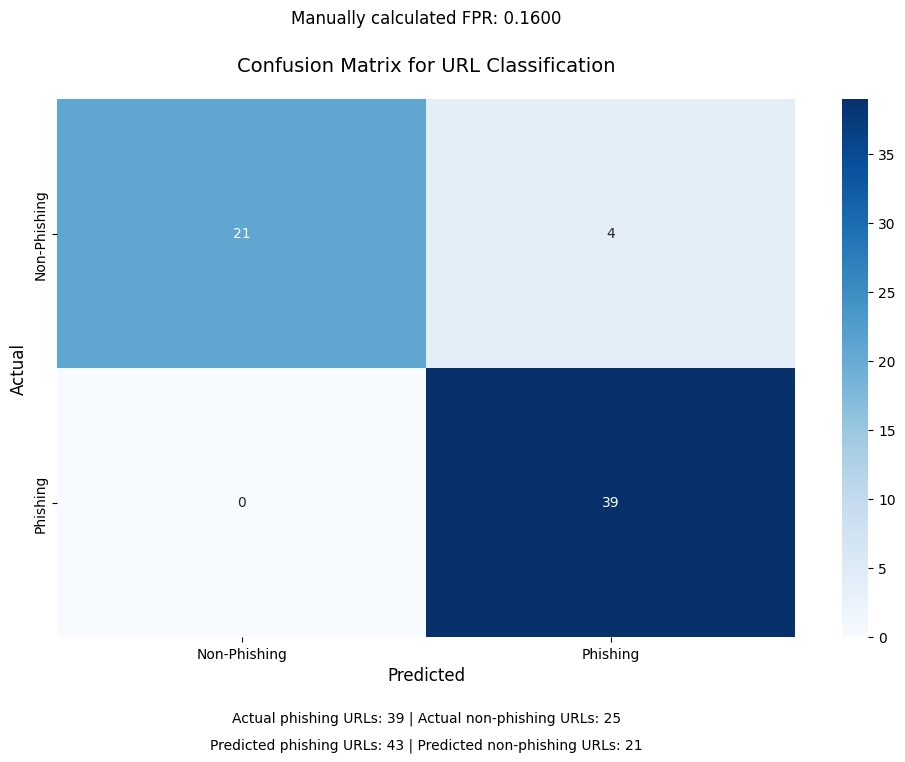

URL classification confusion matrix saved as 'url_classification_confusion_matrix.png'


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data
confusion_matrix = np.array([[21, 4],
                             [0, 39]])

actual_phishing = 39
actual_non_phishing = 25
predicted_phishing = 43
predicted_non_phishing = 21
manually_calculated_fpr = 0.1600

# Create the plot
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Non-Phishing', 'Phishing'],
            yticklabels=['Non-Phishing', 'Phishing'])

# Set labels and title
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix for URL Classification', fontsize=14, pad=20)

# Add text annotations
plt.text(0.5, 1.15, f'Manually calculated FPR: {manually_calculated_fpr:.4f}', 
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

plt.text(0.5, -0.15, f'Actual phishing URLs: {actual_phishing} | Actual non-phishing URLs: {actual_non_phishing}', 
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.20, f'Predicted phishing URLs: {predicted_phishing} | Predicted non-phishing URLs: {predicted_non_phishing}', 
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)

# Adjust layout and save
plt.tight_layout()
plt.show()
plt.savefig('url_classification_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

print("URL classification confusion matrix saved as 'url_classification_confusion_matrix.png'")

- Test Metrics ---
Accuracy: 0.9778
Precision: 0.9785
Recall: 0.9778
F1 Score: 0.9779
False Positive Rate: 0.0324
ROC AUC: 0.9979
Optimal Threshold: 0.0017
Confusion Matrix:
[[1615   54]
 [   8 1119]]

Prediction distribution:
Positive predictions: 1173
Negative predictions: 1623

True label distribution:
Positive labels: 1127
Negative labels: 1669